# Data Import & Cleaning

##### Importing the modules

In [99]:
import pandas as pd
import numpy as np
import re
from scipy.stats import iqr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

##### Importing the dataset

In [5]:
train_data = pd.read_csv(r"C:\Users\olivia\Downloads\BDA OL5 24-25 Paper 1 - Dataset\apartment_for_rent_train.csv")
test_data = pd.read_csv(r"C:\Users\olivia\Downloads\BDA OL5 24-25 Paper 1 - Dataset\apartment_for_rent_test.csv")


In [7]:
print(train_data.columns)
print(test_data.columns)

Index(['Reg_id', 'Gender', 'Age', 'Construction_type', 'New_construction',
       'Elevator', 'Floors_in_the_building', 'Floor_area', 'Number_of_rooms',
       'Number_of_bathrooms', 'Ceiling_height', 'Floor', 'Balcony',
       'Furniture', 'Renovation', 'Children_are_welcome', 'Pets_allowed',
       'Utility_payments', 'Address', 'Price', 'Currency', 'Duration',
       'Datetime', 'amenities', 'appliances', 'parking'],
      dtype='object')
Index(['New_construction', 'Elevator', 'Floors_in_the_building', 'Floor_area',
       'Number_of_rooms', 'Number_of_bathrooms', 'Ceiling_height', 'Floor',
       'Balcony', 'Furniture', 'Renovation', 'Children_are_welcome',
       'Pets_allowed', 'Utility_payments', 'Address', 'Price', 'Currency',
       'Duration', 'Datetime', 'amenities', 'appliances', 'parking',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')


In [8]:
correct_columns = ['Reg_id', 'Gender', 'Age', 'Construction_type', 'New_construction', 'Elevator',
 'Floors_in_the_building', 'Floor_area', 'Number_of_rooms', 'Number_of_bathrooms',
 'Ceiling_height', 'Floor', 'Balcony', 'Furniture', 'Renovation',
 'Children_are_welcome', 'Pets_allowed', 'Utility_payments', 'Address', 'Price',
 'Currency', 'Duration', 'Datetime', 'amenities', 'appliances', 'parking']

test_data.columns = correct_columns



##### Inspect Before Cleaning & check for Structural Errors

In [11]:
### labelling the datasets
train_data['is_train'] = True
test_data['is_train'] = False
# Combine the datasets for consistent cleaning and transformation, creating one dataset of train and test
data = pd.concat([train_data, test_data], ignore_index=True)

In [12]:
data.nunique()

Reg_id                      13
Gender                       2
Age                         53
Construction_type           12
New_construction             2
Elevator                     2
Floors_in_the_building      30
Floor_area                 270
Number_of_rooms              9
Number_of_bathrooms          4
Ceiling_height               9
Floor                       23
Balcony                      9
Furniture                    8
Renovation                  14
Children_are_welcome         6
Pets_allowed                 6
Utility_payments             6
Address                   5663
Price                      371
Currency                     4
Duration                     2
Datetime                     4
amenities                   17
appliances                 203
parking                      9
is_train                     2
dtype: int64

In [14]:
shape = test_data.shape
columns = test_data.columns.tolist()
dtypes = test_data.dtypes
missing_values = test_data.isnull().sum()
sample_data = test_data.head()
number_unique_records = test_data.nunique()


In [15]:
print(shape)
print("")
print(columns)
print("")
print(dtypes)
print("")
print(missing_values) ### Lots of missing values
print("")
print(sample_data)

(8147, 27)

['Reg_id', 'Gender', 'Age', 'Construction_type', 'New_construction', 'Elevator', 'Floors_in_the_building', 'Floor_area', 'Number_of_rooms', 'Number_of_bathrooms', 'Ceiling_height', 'Floor', 'Balcony', 'Furniture', 'Renovation', 'Children_are_welcome', 'Pets_allowed', 'Utility_payments', 'Address', 'Price', 'Currency', 'Duration', 'Datetime', 'amenities', 'appliances', 'parking', 'is_train']

Reg_id                      int64
Gender                     object
Age                         int64
Construction_type          object
New_construction            int64
Elevator                    int64
Floors_in_the_building      int64
Floor_area                float64
Number_of_rooms             int64
Number_of_bathrooms         int64
Ceiling_height            float64
Floor                       int64
Balcony                    object
Furniture                  object
Renovation                 object
Children_are_welcome        int64
Pets_allowed                int64
Utility_payment

In [29]:
### checking for under-representation in the data
for col in data.columns:
    print(data[col].value_counts(dropna=False))

Reg_id
1     38533
4       595
5       581
2       235
6       232
10      210
3       100
7        78
11       72
8        43
9        30
13       15
12       10
Name: count, dtype: int64
Gender
Female    20441
Male      20293
Name: count, dtype: int64
Age
30    835
25    823
23    818
32    817
51    814
39    809
68    807
31    805
61    800
63    799
19    799
45    791
42    790
33    790
62    786
21    785
18    783
56    781
22    780
66    776
35    776
59    775
52    775
47    774
43    771
65    770
26    769
55    769
37    767
60    766
28    765
48    763
58    763
41    762
34    761
24    760
57    756
44    751
69    749
49    747
38    746
67    744
64    741
53    741
54    739
50    733
40    732
46    724
70    722
29    716
36    715
20    704
27    700
Name: count, dtype: int64
Construction_type
Monolith    13986
Stone       12070
Panels       6955
stone        2988
monolith     2717
panels       1884
Bricks         65
Cassette       37
bricks         14
casset

##### 3) Data preparation - cleaning & transforming data



##### Locating issues to clean

In [35]:
combined_data = data

# Step 1: NA-like string values
possible_na_values = ['na', 'NA', 'NaN', 'nan', '', ' ', 'null', 'NULL']
string_na_counts = {col: combined_data[col].astype(str).isin(possible_na_values).sum() for col in combined_data.columns}

# Step 2: isnull() values
isnull_counts = combined_data.isnull().sum().to_dict()

# Step 3: Mixed types
mixed_type_counts = {}
for col in combined_data.columns:
    types = combined_data[col].map(type).value_counts()
    if len(types) > 1:
        mixed_type_counts[col] = {str(k): int(v) for k, v in types.items()}

# Step 4: Implausible values
implausible_counts = {
    'Age': ((pd.to_numeric(combined_data['Age'], errors='coerce') < 0) | (pd.to_numeric(combined_data['Age'], errors='coerce') > 120)).sum(),
    'Floor_area': (pd.to_numeric(combined_data['Floor_area'], errors='coerce') <= 0).sum(),
    'Number_of_rooms': (pd.to_numeric(combined_data['Number_of_rooms'], errors='coerce') <= 0).sum(),
    'Number_of_bathrooms': (pd.to_numeric(combined_data['Number_of_bathrooms'], errors='coerce') < 0).sum(),
    'Ceiling_height': (pd.to_numeric(combined_data['Ceiling_height'], errors='coerce') <=0).sum(),
    'Price': (pd.to_numeric(combined_data['Price'], errors='coerce') <= 0).sum(),
    'Duration': (pd.to_numeric(combined_data['Duration'], errors='coerce') <= 0).sum()
}

# Step 5: Outliers using IQR
numerics = combined_data.select_dtypes(include='number')
Q1 = numerics.quantile(0.25)
Q3 = numerics.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numerics < (Q1 - 1.5 * IQR)) | (numerics > (Q3 + 1.5 * IQR))).sum().to_dict()

# Combine all summaries into one DataFrame
summary_df = pd.DataFrame({
    "isnull_count": pd.Series(isnull_counts),
    "string_na_count": pd.Series(string_na_counts),
    "outliers": pd.Series(outliers),
    "implausible_values": pd.Series(implausible_counts)
}).fillna(0).astype(int)

summary_df

isnull_count  string_na_count  outliers  \
Address                            2                2         0   
Age                                0                0         0   
Balcony                           11               11         0   
Ceiling_height                     3                3       844   
Children_are_welcome             559              559         0   
Construction_type                  7                7         0   
Currency                           2                2         0   
Datetime                           2                2         0   
Duration                           2                2         0   
Elevator                           2                2         0   
Floor                              2                2      1229   
Floor_area                        10               10      1740   
Floors_in_the_building             1                1       139   
Furniture                      12441            12441         0   
Gender                             0                0         0   
New_construction                   2                2         0   
Number_of_bathrooms                3                3      7369   
Number_of_rooms                    2                2       582   
Pets_allowed                     559              559         0   
Price                              2                2       682   
Reg_id                             0                0      2201   
Renovation                         9                9         0   
Utility_payments                 559              559         0   
amenities                       5132             5132         0   
appliances                      5126             5126         0   
is_train                           0                0         0   
parking                         5697             5697         0   

                        implausible_values  
Address                                  0  
Age                                      0  
Balcony                                  0  
Ceiling_height                          10  
Children_are_welcome                     0  
Construction_type                        0  
Currency                                 0  
Datetime                                 0  
Duration                                 0  
Elevator                                 0  
Floor                                    0  
Floor_area                               0  
Floors_in_the_building                   0  
Furniture                                0  
Gender                                   0  
New_construction                         0  
Number_of_bathrooms                      0  
Number_of_rooms                          6  
Pets_allowed                             0  
Price                                    0  
Reg_id                                   0  
Renovation                               0  
Utility_payments                         0  
amenities                                0  
appliances                               0  
is_train                                 0  
parking                                  0

### Cleaning the data

#### Mixed data types

Due to the findings above, we might want to keep these and just convert to string as they may have some reference / importance to the model, the volume is also high and i can't check with stakeholders on the value meanings.

“Attribute selection should consider domain knowledge. Encoding should match data semantics — don’t treat nominal values as ordinal unless you’re sure.” 8.1.

Volume is high enough in certain brackets to NOT make assumptions.

In [42]:
# Columns with mixed types but unclear numeric meaning
mixed_categorical_columns = [
    'Construction_type', 'Balcony', 'Furniture', 'Renovation', 'Address',
    'Currency', 'Duration', 'Datetime', 'amenities', 'appliances', 'parking'
]

# Convert all values in these columns to strings to preserve original values
for col in mixed_categorical_columns:
    data[col] = data[col].astype(str).str.strip().str.lower()



In [44]:
mixed_type_counts_new = {}
for col in combined_data.columns:
    types = combined_data[col].map(type).value_counts()
    if len(types) > 1:
        mixed_type_counts[col] = {str(k): int(v) for k, v in types.items()}

mixed_type_counts_new


{}

#### Filling NAs


In [47]:
import numpy as np

# Define the string values to treat as missing (case-insensitive, space-stripped)
na_strings = ['na', 'nan', 'null', 'none', '']
na_strings = set(s.strip().lower() for s in na_strings)

# Function to clean a single value
def clean_string_na(val):
    if isinstance(val, str) and val.strip().lower() in na_strings:
        return np.nan
    return val

# Apply the cleaning function to all object columns
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].apply(clean_string_na).fillna('missing')

numeric_columns = data.select_dtypes(include=['number']).columns
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].fillna(data[col].median())



In [49]:
missing_summary = data.isnull().sum()
missing_summary

Reg_id                    0
Gender                    0
Age                       0
Construction_type         0
New_construction          0
Elevator                  0
Floors_in_the_building    0
Floor_area                0
Number_of_rooms           0
Number_of_bathrooms       0
Ceiling_height            0
Floor                     0
Balcony                   0
Furniture                 0
Renovation                0
Children_are_welcome      0
Pets_allowed              0
Utility_payments          0
Address                   0
Price                     0
Currency                  0
Duration                  0
Datetime                  0
amenities                 0
appliances                0
parking                   0
is_train                  0
dtype: int64

#### Implausible Values

input the median

In [51]:
numeric_columns = data.select_dtypes(include=['number']).columns

rooms = ['Number_of_rooms']
ceiling = ['Ceiling_height']



# Replace implausible values (< 1) with median for selected columns
rooms = ['Number_of_rooms']
ceiling = ['Ceiling_height']

for col in rooms + ceiling:
    # Ensure column is numeric (just in case)
    data[col] = pd.to_numeric(data[col], errors='coerce')

    # Compute median from plausible values (>= 1)
    valid_median = data.loc[data[col] >= 1, col].median()

    # Replace values < 1 with the median
    invalid_count = (data[col] < 1).sum()
    if invalid_count > 0:
        data.loc[data[col] < 1, col] = valid_median
        print(f"Replaced {invalid_count} implausible values in '{col}' with median: {valid_median}")

for col in numeric_columns:
    # Ensure column is numeric (just in case)
    data[col] = pd.to_numeric(data[col], errors='coerce')

    # Compute median from plausible values (>= 1)
    valid_median = data.loc[data[col] >= 1, col].median()

    # Replace values < 1 with the median
    invalid_count = (data[col] < 0).sum()
    if invalid_count > 0:
        data.loc[data[col] < 1, col] = valid_median
        print(f"Replaced {invalid_count} implausible values in '{col}' with median: {valid_median}")


Replaced 6 implausible values in 'Number_of_rooms' with median: 2.0
Replaced 10 implausible values in 'Ceiling_height' with median: 3.0
Replaced 2 implausible values in 'Floors_in_the_building' with median: 9.0


#### Outlier inputation

Using IQR for simplicity

Witten 2.2 page 33-34

Outlier on Price first, due to our Y and having huge variance

In [57]:

# List of numeric columns (excluding ID)
columns_with_outliers = [
    'Ceiling_height', 'Floor', 'Floor_area',
    'Floors_in_the_building', 'Number_of_bathrooms',
    'Number_of_rooms', 'Price'
]

price_col = ['Price']
for col in price_col:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count how many are outliers
    outliers = (data[col] < lower_bound) | (data[col] > upper_bound)
    outlier_count = outliers.sum()

    # Replace outliers with median
    median_value = data[col].median()
    data.loc[outliers, col] = median_value

    print(f"{col}: {outlier_count} outliers replaced with median value {median_value:.2f}")

Price: 682 outliers replaced with median value 5500.00


In [305]:
# Calculate IQR bounds
Q1 = data['Floor_area'].quantile(0.25)
Q3 = data['Floor_area'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with median
median_value = data.loc[(data['Floor_area'] >= lower_bound) & (data['Floor_area'] <= upper_bound), 'Floor_area'].median()
outliers = (data['Floor_area'] < lower_bound) | (data['Floor_area'] > upper_bound)
data.loc[outliers, 'Floor_area'] = median_value

print(f"Replaced {outliers.sum()} outliers in 'Floor_area' with median: {median_value}")


Replaced 1740 outliers in 'Floor_area' with median: 67.0


#### Handling Delimiters


In [59]:
import re

def clean_category(val):
    if isinstance(val, str):
        # Lowercase, replace _ and - with space, strip extra whitespace
        val = val.lower()
        val = re.sub(r'[_\-]', ' ', val)
        val = re.sub(r'\s+', ' ', val).strip()
    return val

# Apply to all categorical columns
categorical_columns = data.select_dtypes(include='object').columns
for col in categorical_columns:
    data[col] = data[col].apply(clean_category)


### --- CLEAN COMPLETED --- ###

### Numeric EDA - Showing Relationships - numerical analysis on Y

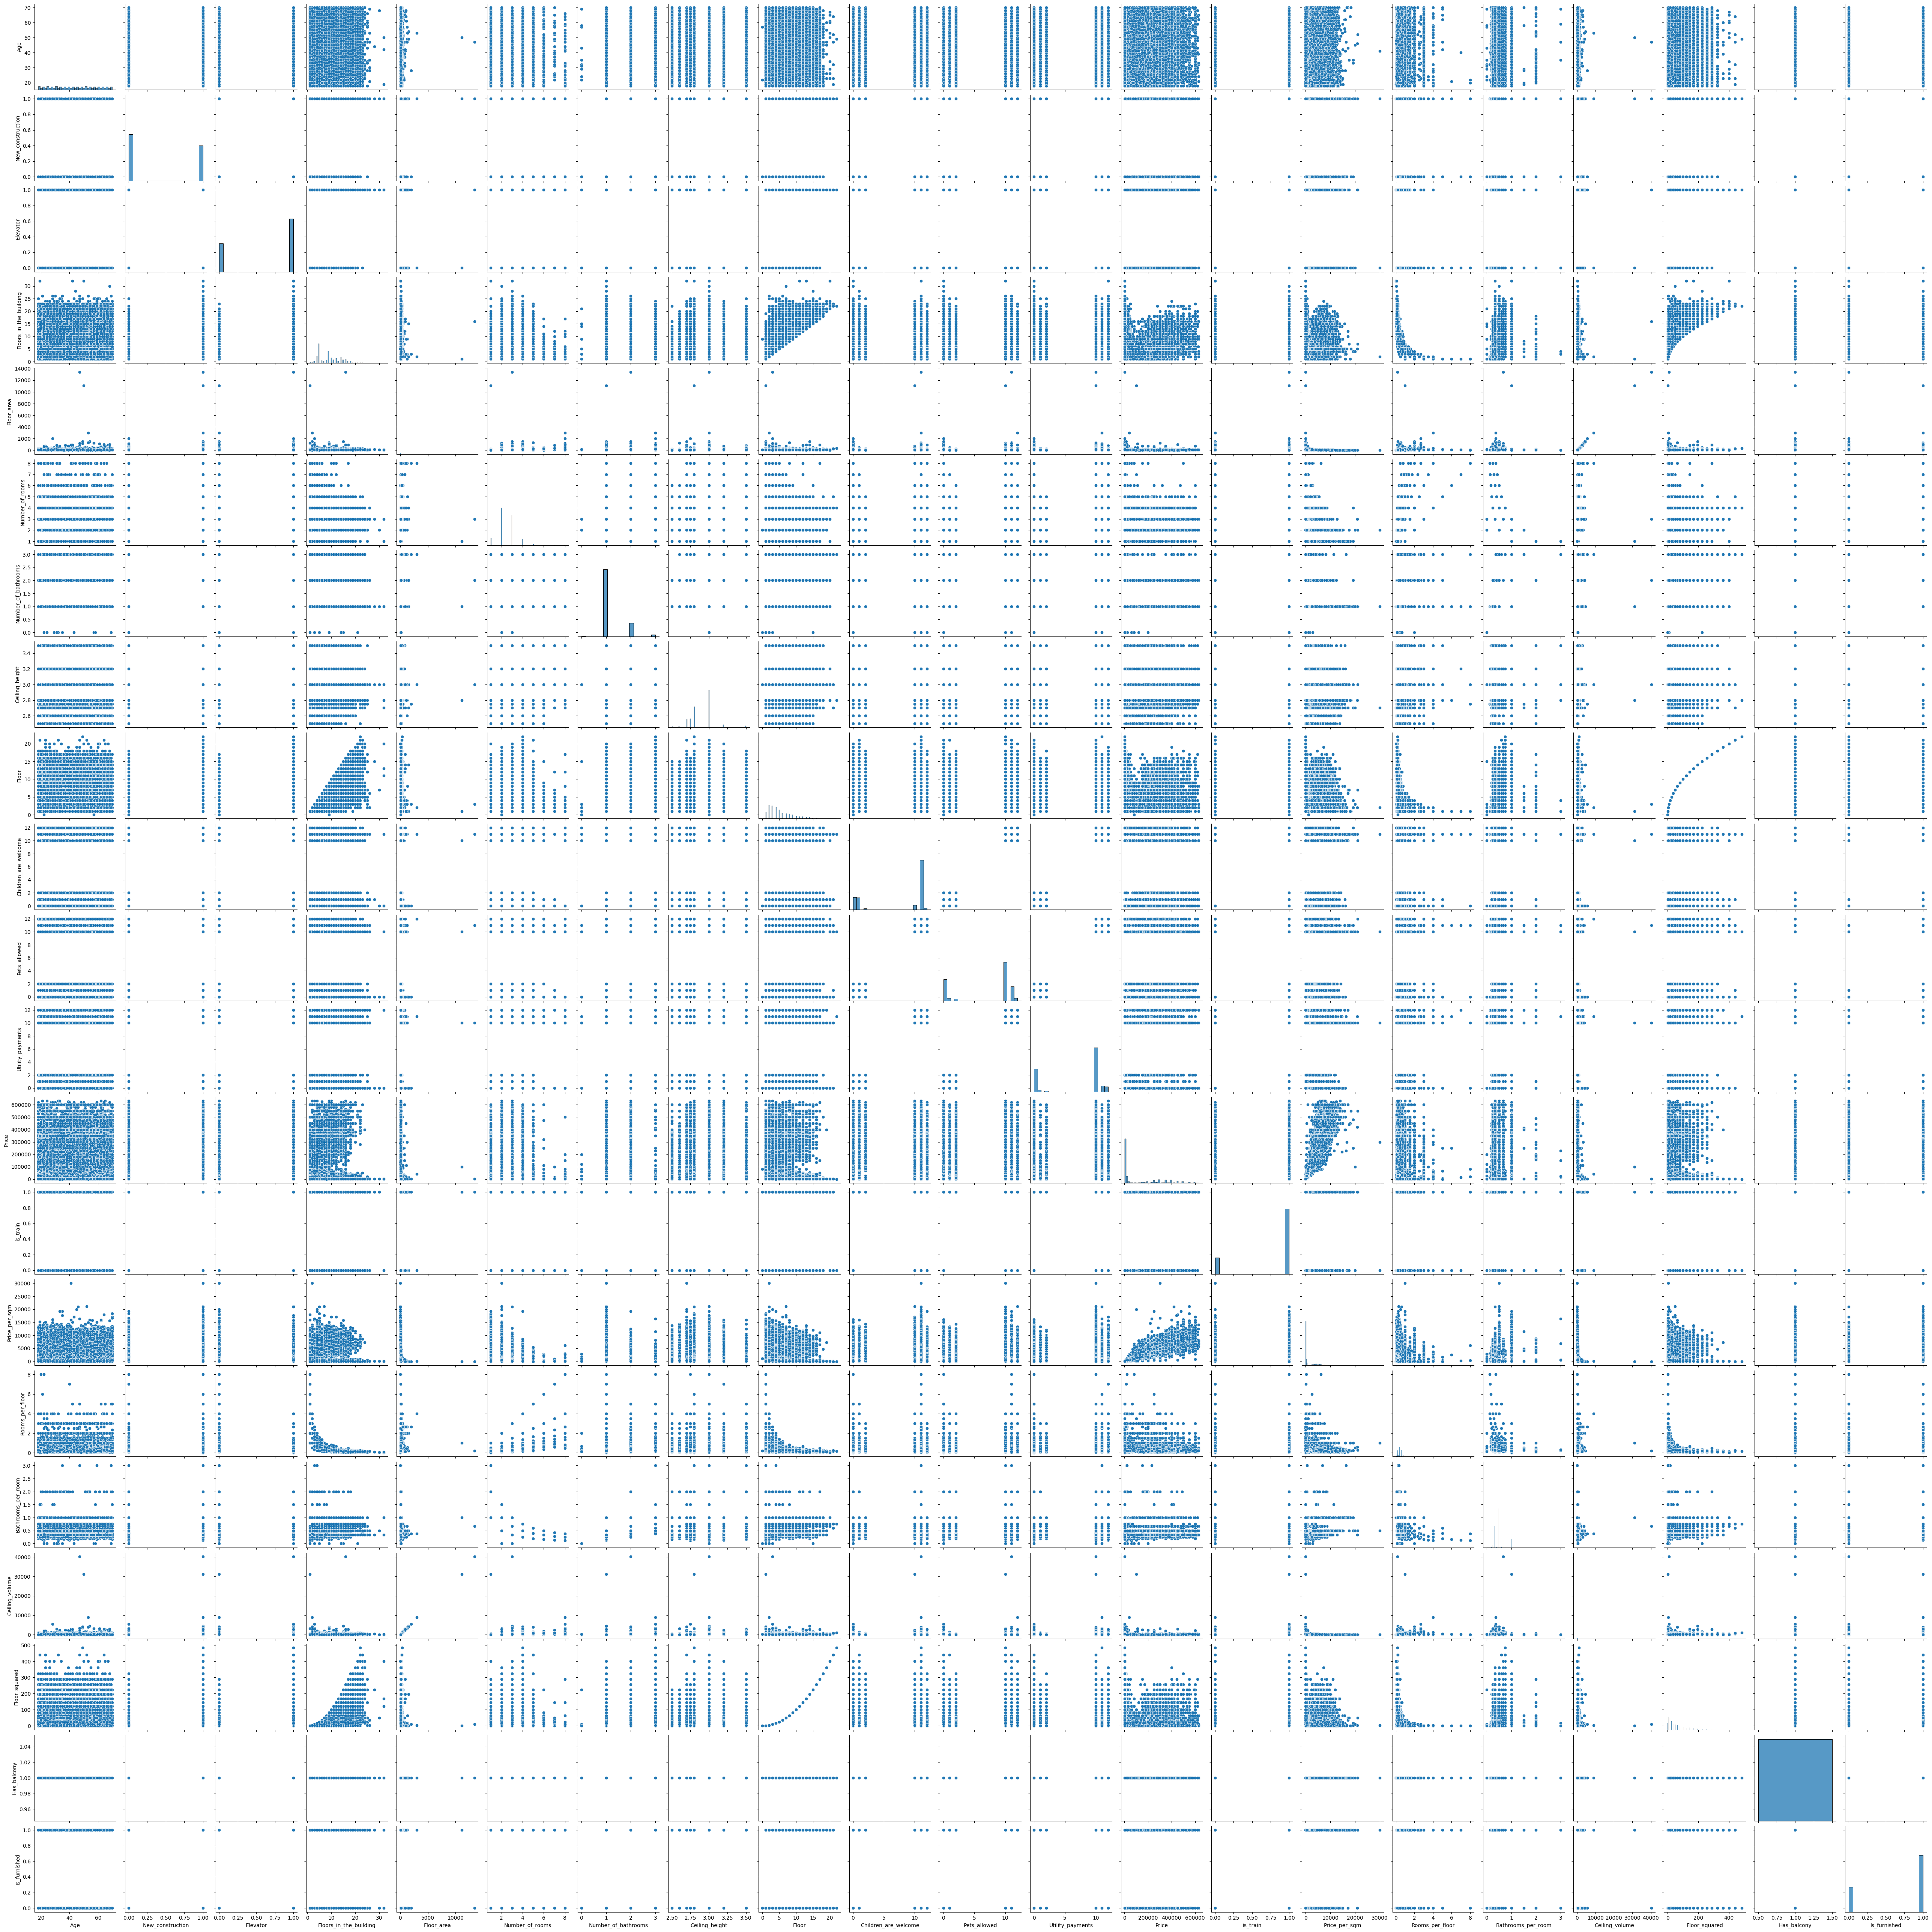

In [163]:
pair=sns.pairplot(data)
pair.savefig(r"C:\Users\olivia\Downloads\cats.png")
plt.show()

### Categorical EDA
Chapter 2 Diez Et al

###### Box Plots

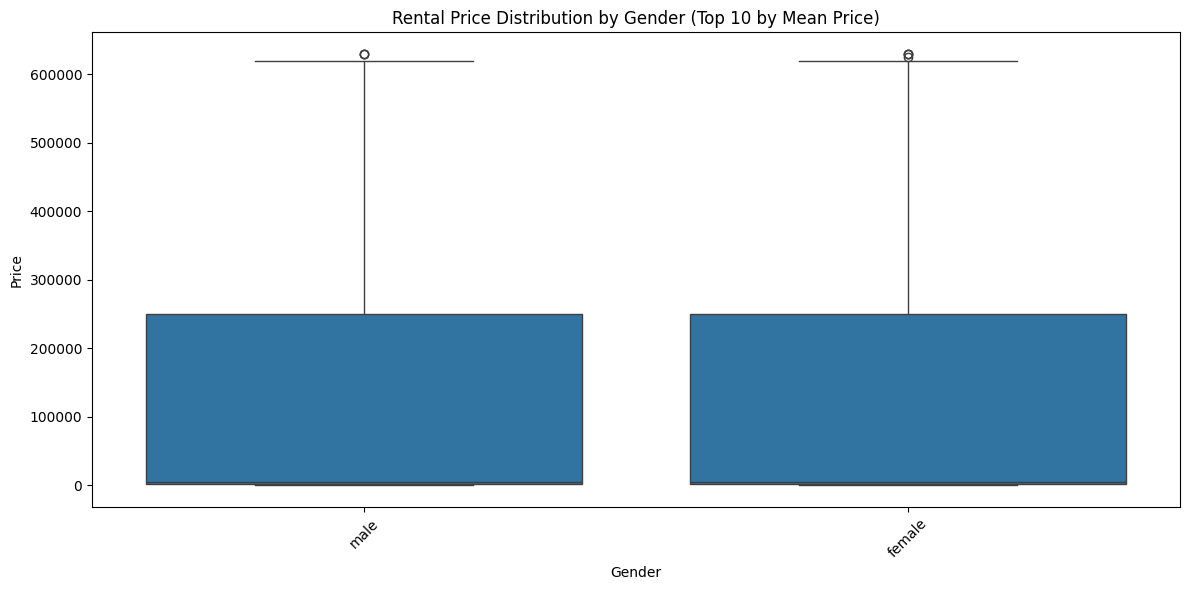

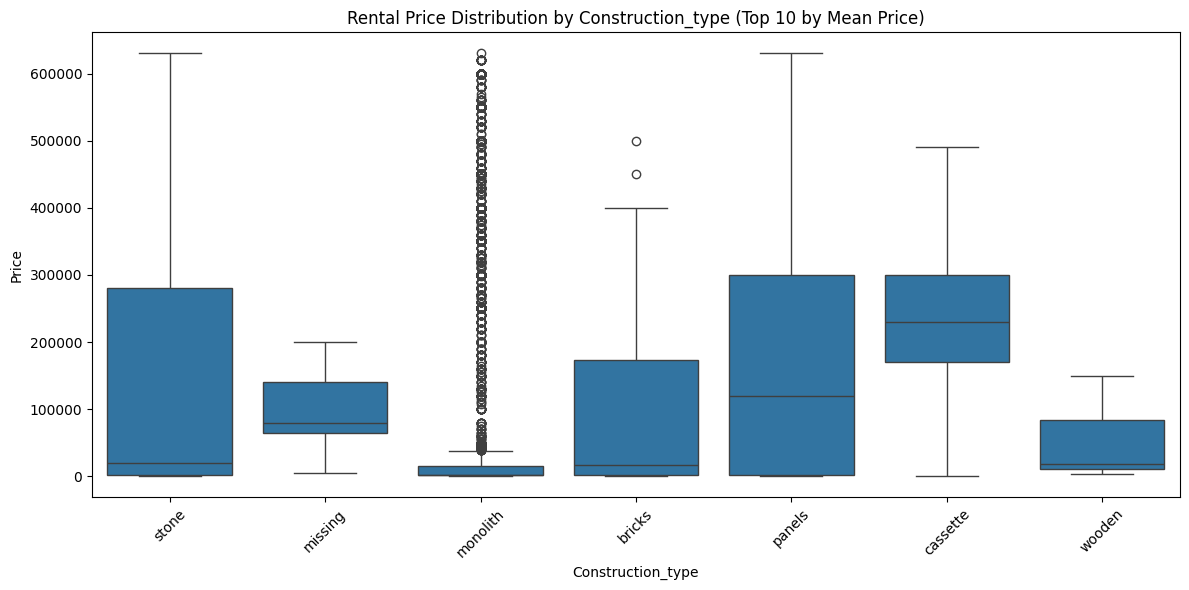

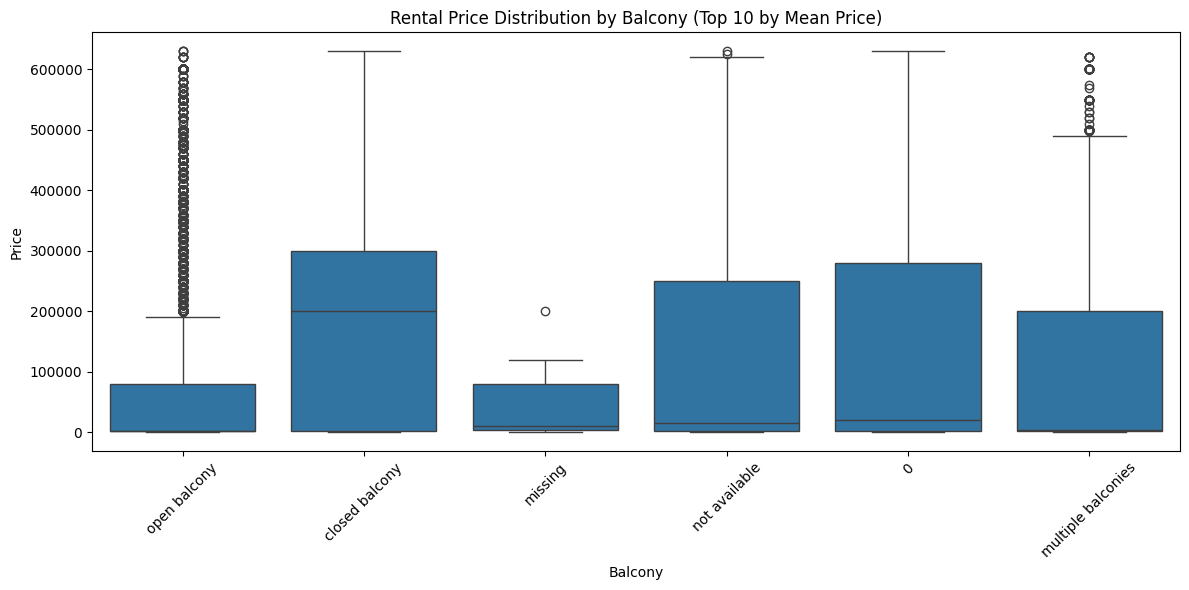

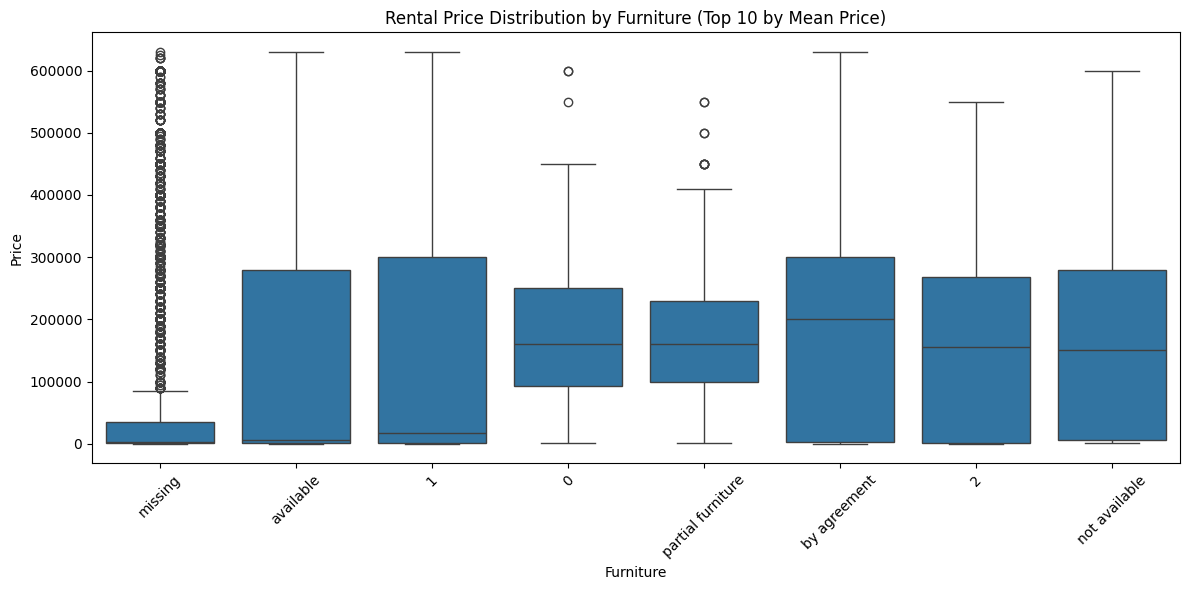

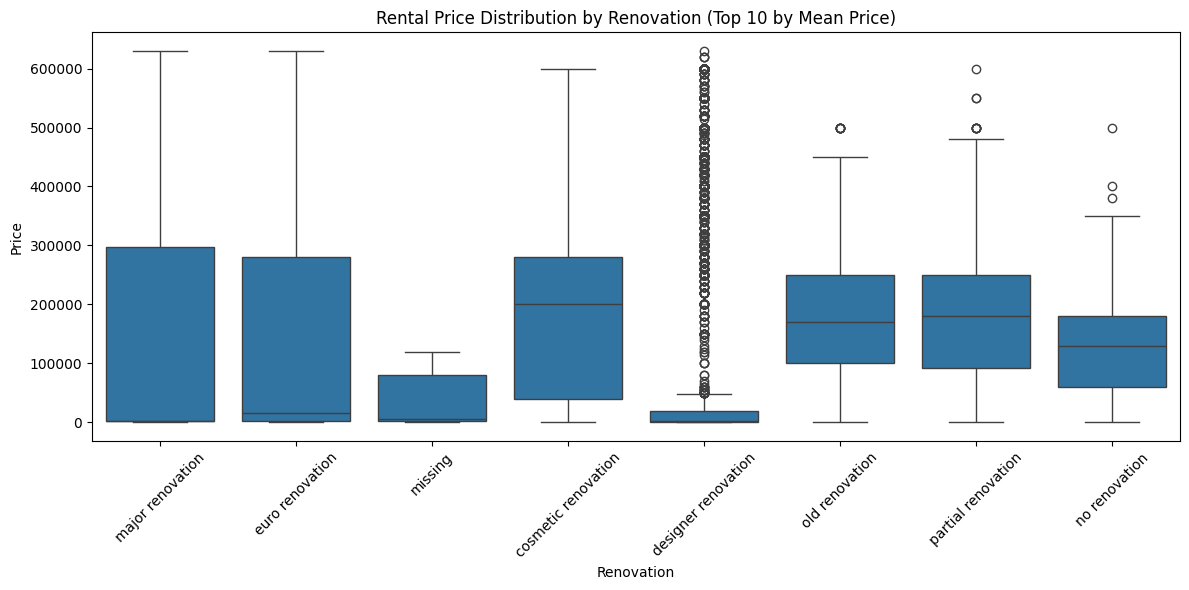

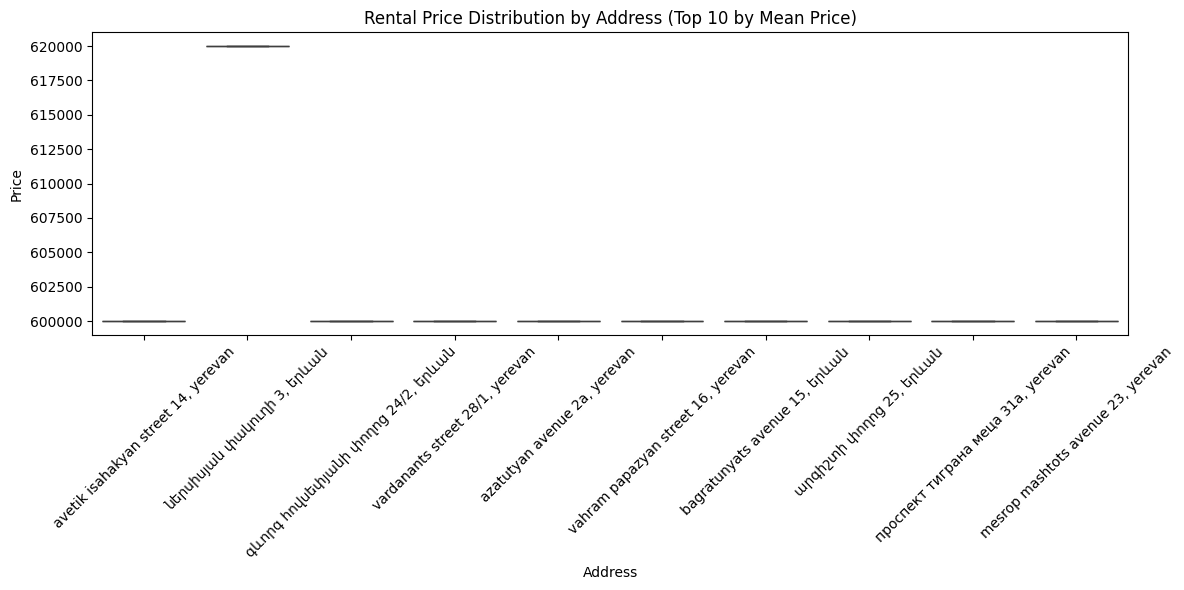

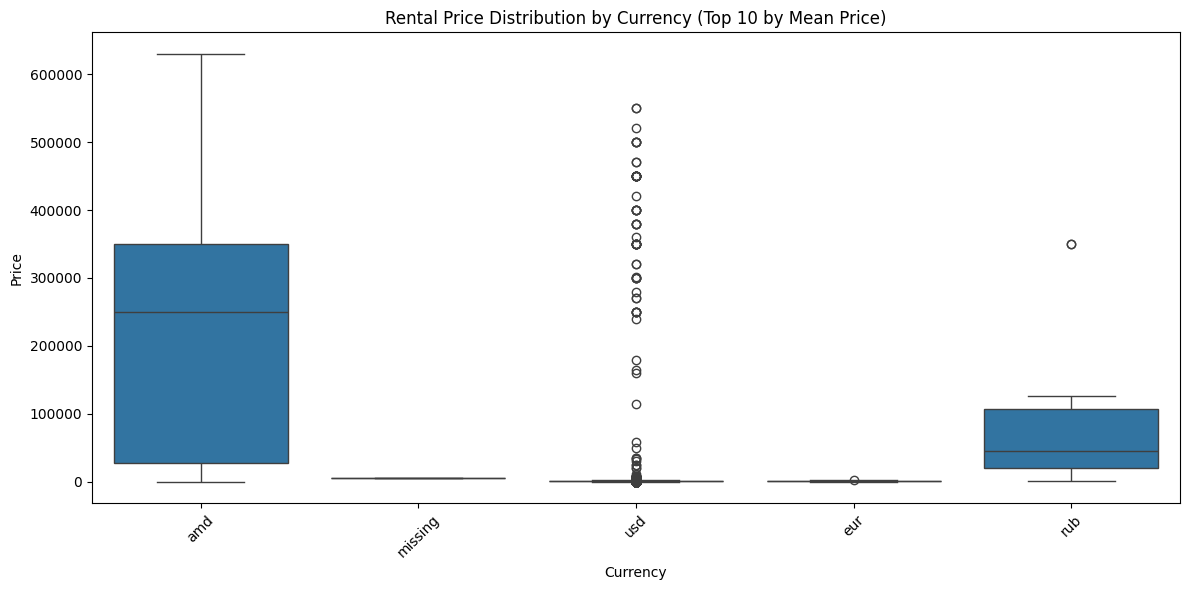

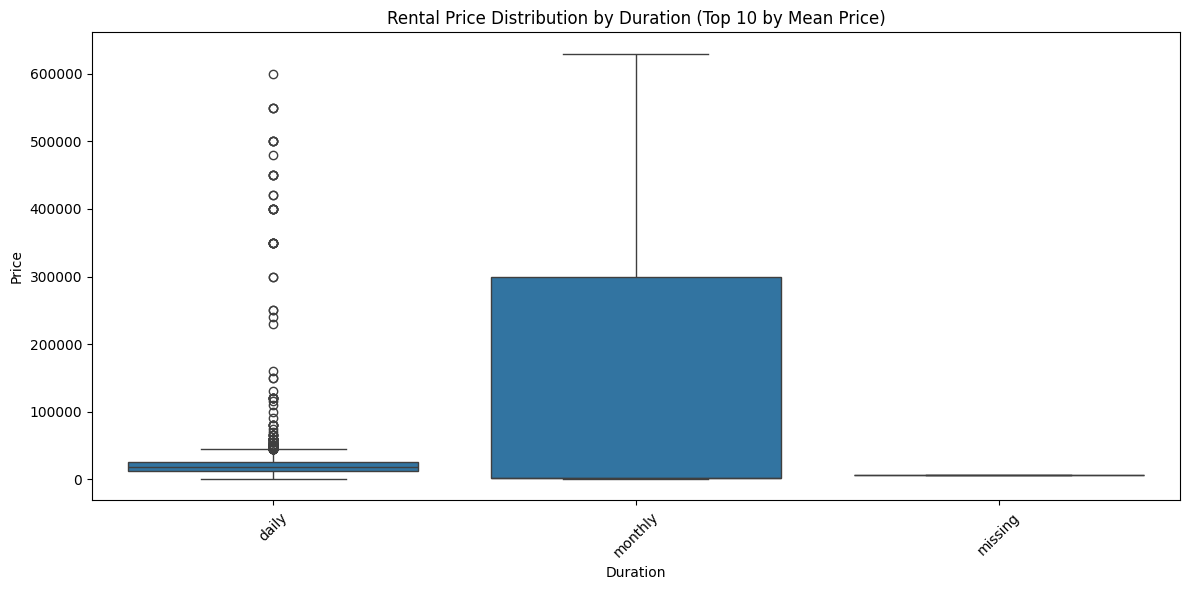

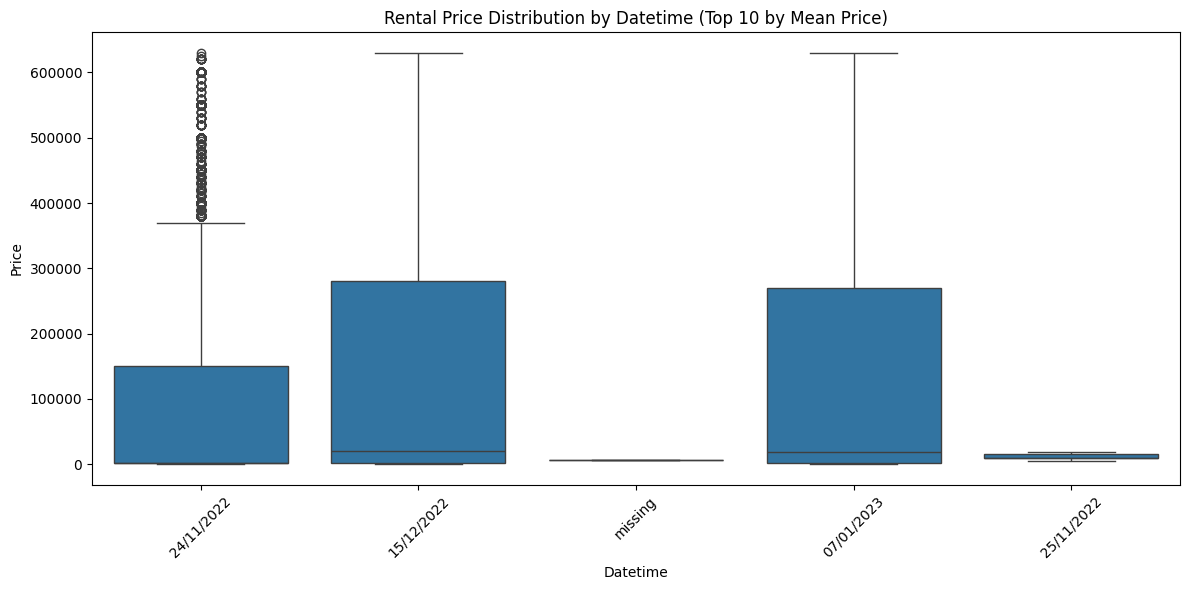

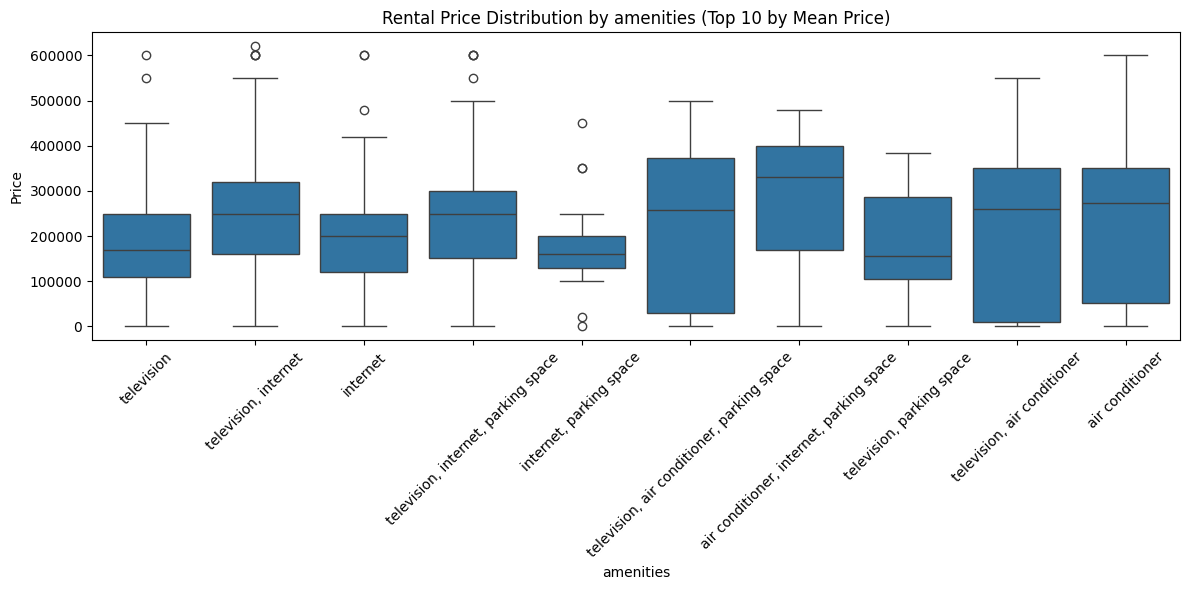

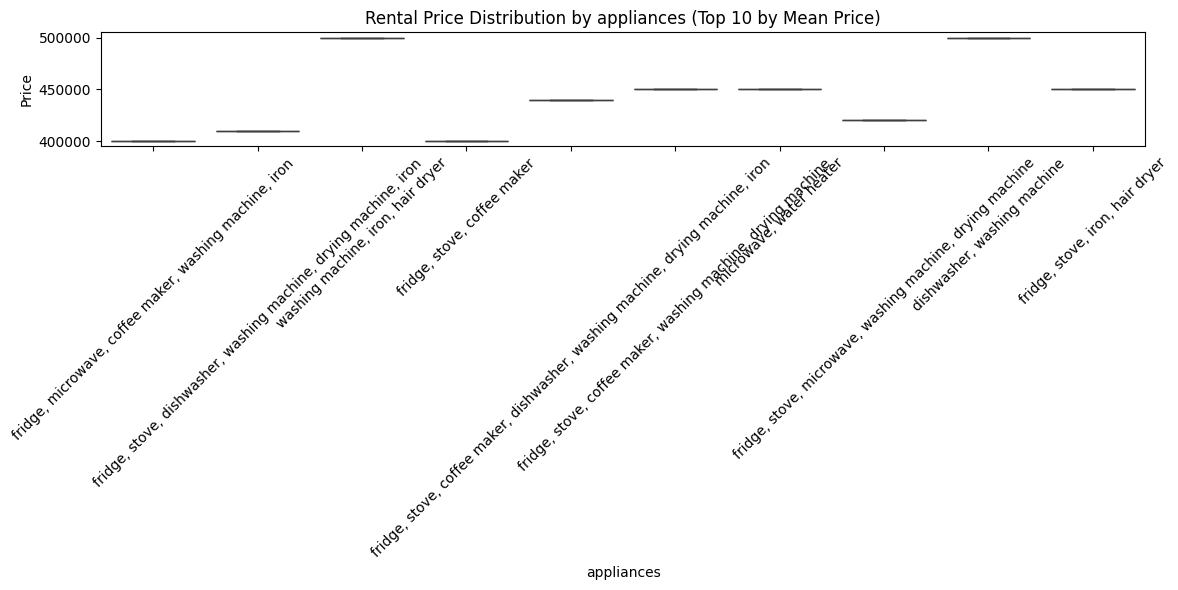

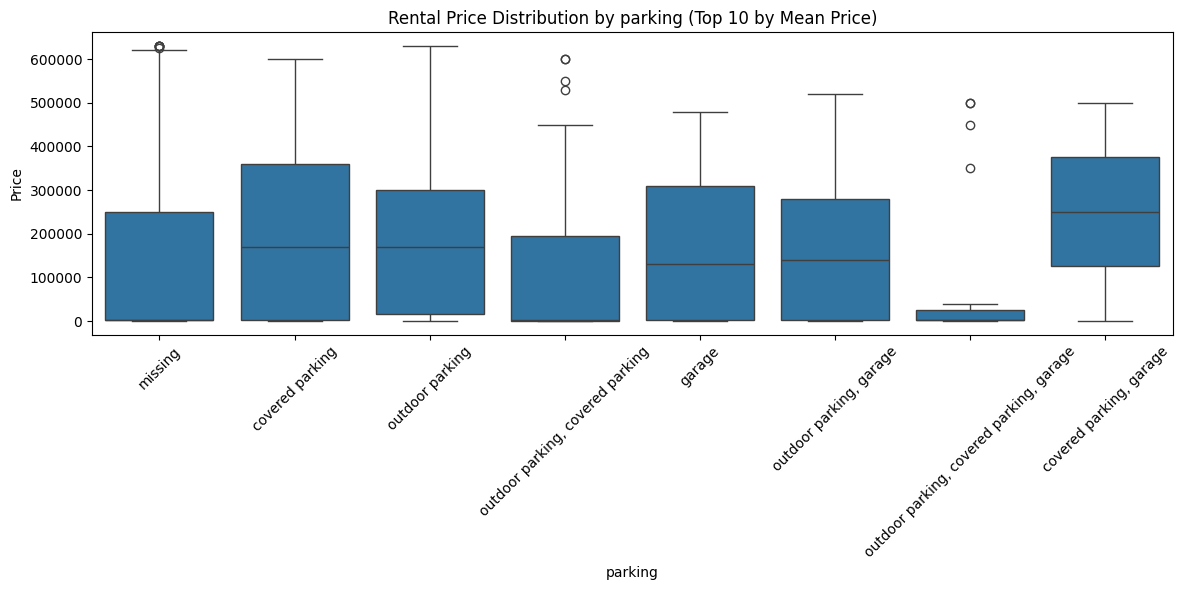

In [71]:
for col in categorical_columns:
    # Calculate mean rental price per category and get top 10
    top_10 = data.groupby(col)['Price'].mean().sort_values(ascending=False).head(10).index

    # Filter the dataset to only include top 10 categories
    filtered = data[data[col].isin(top_10)]

    # Create boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=col, y='Price', data=filtered)
    plt.title(f"Rental Price Distribution by {col} (Top 10 by Mean Price)")
    plt.ylabel("Price")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()



###### Bar plots

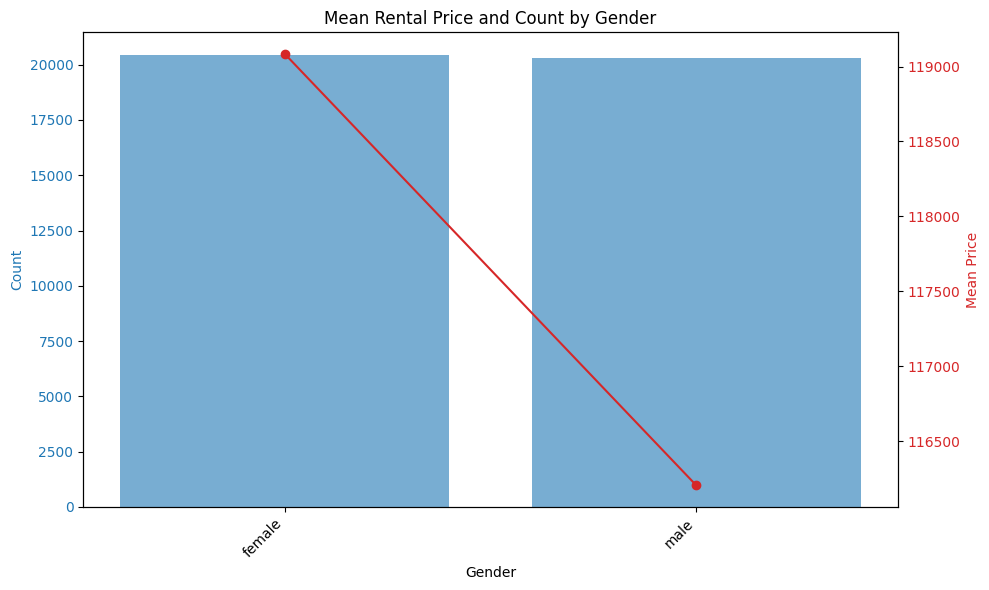

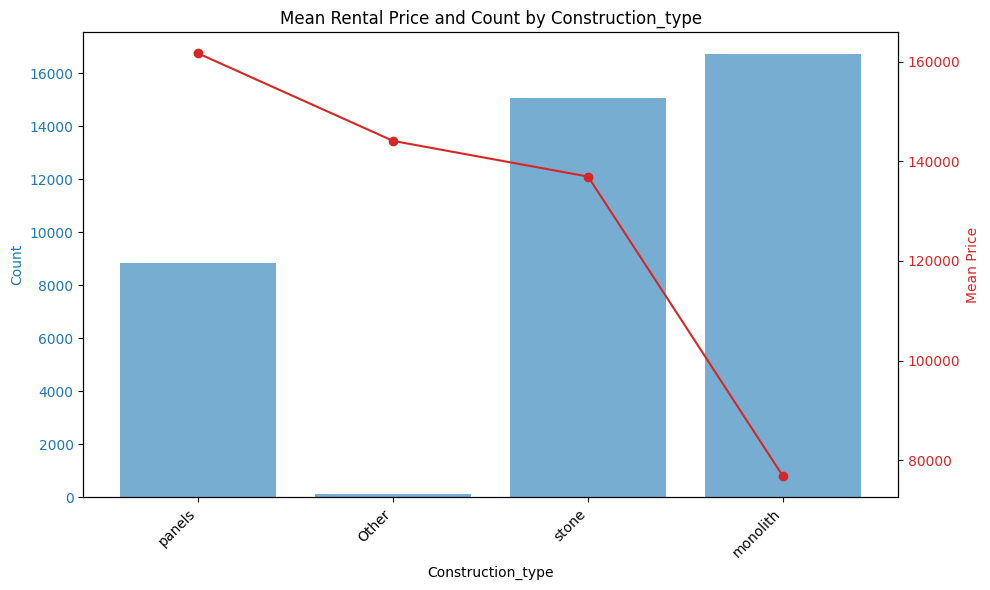

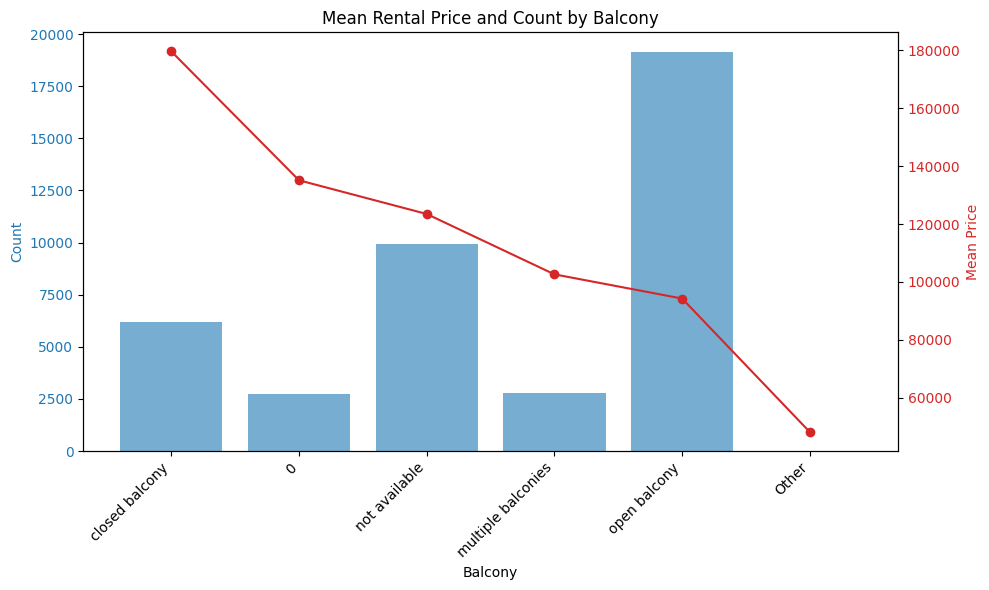

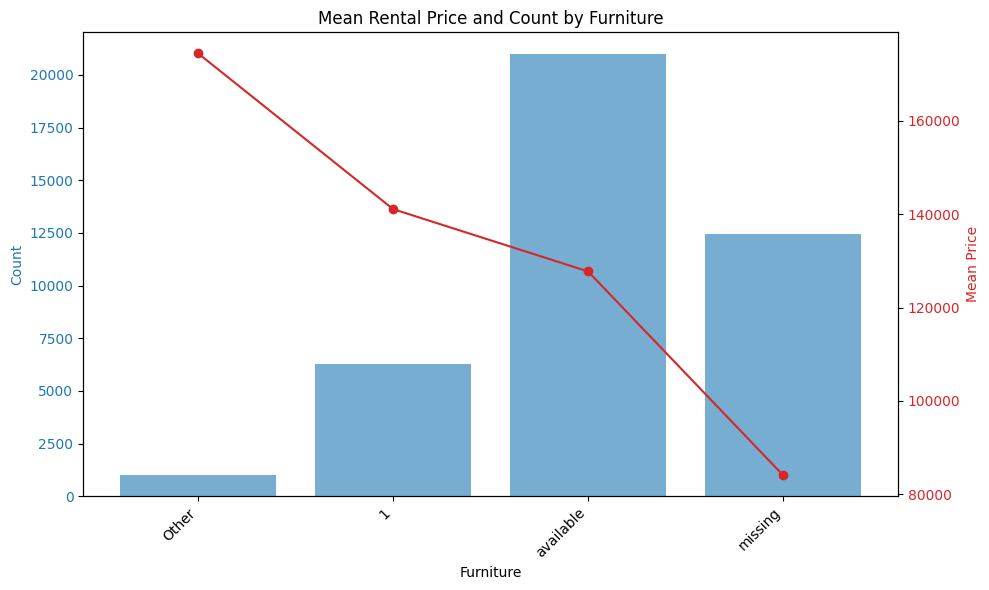

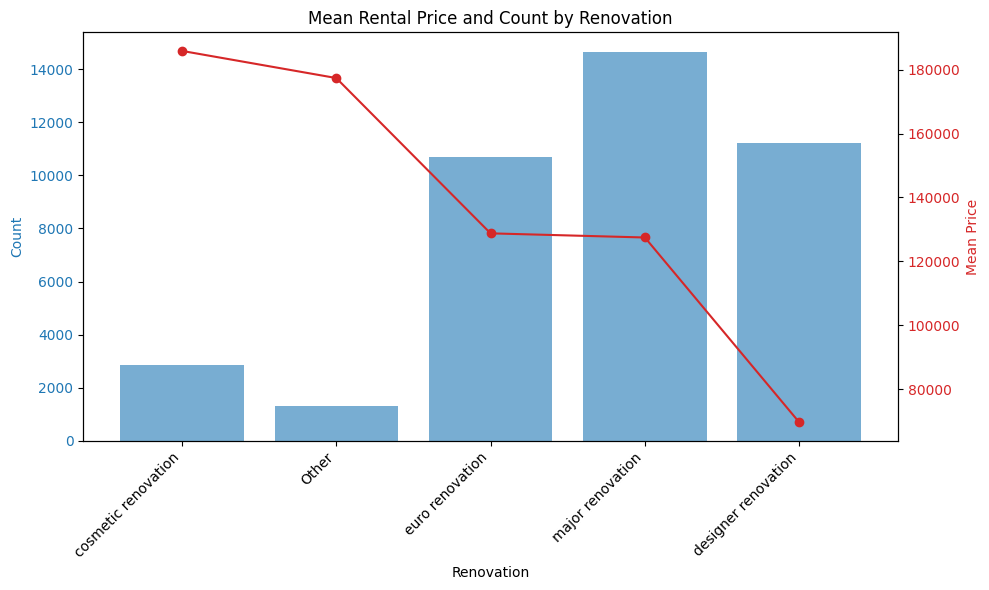

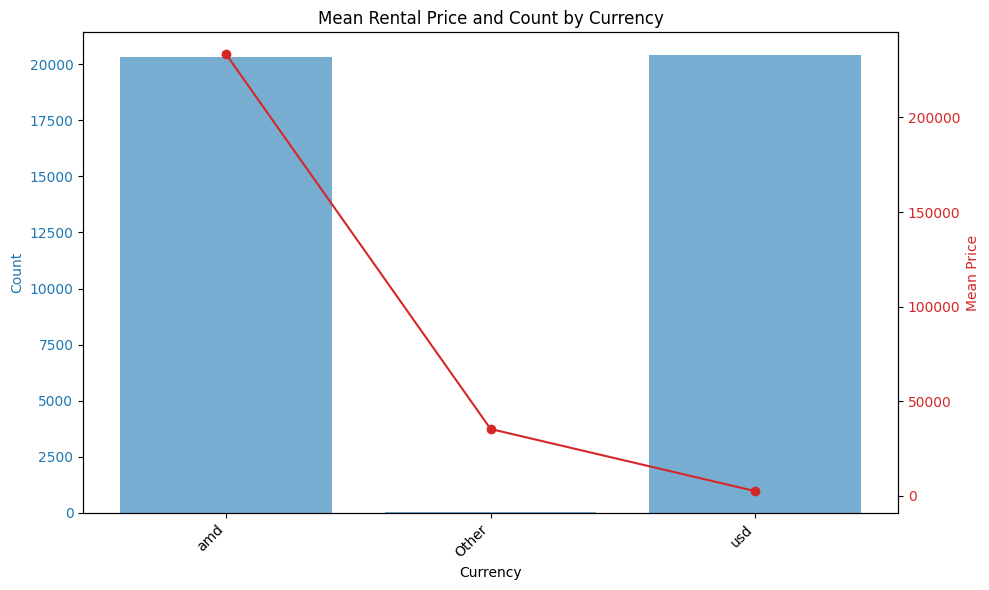

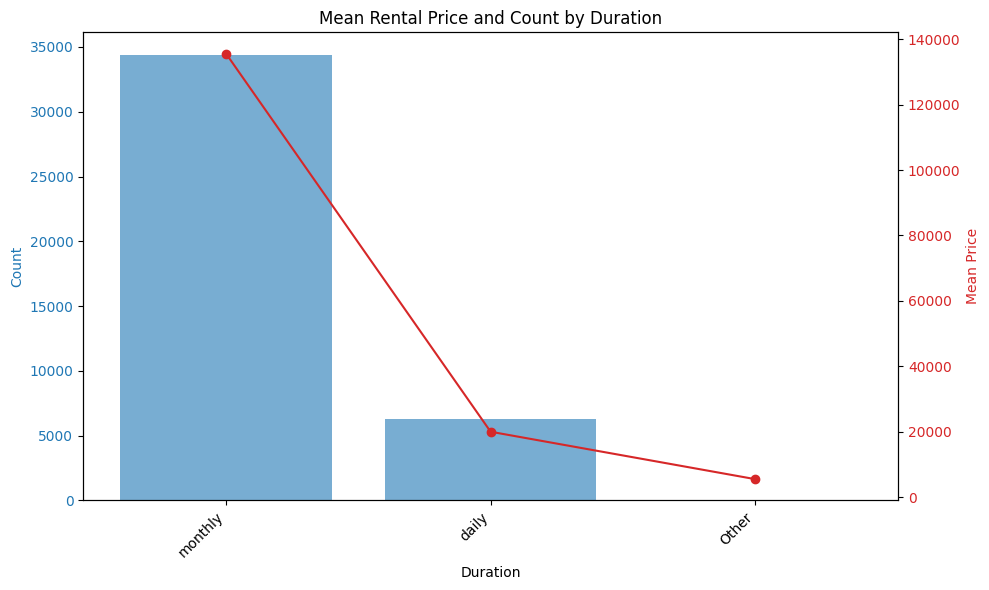

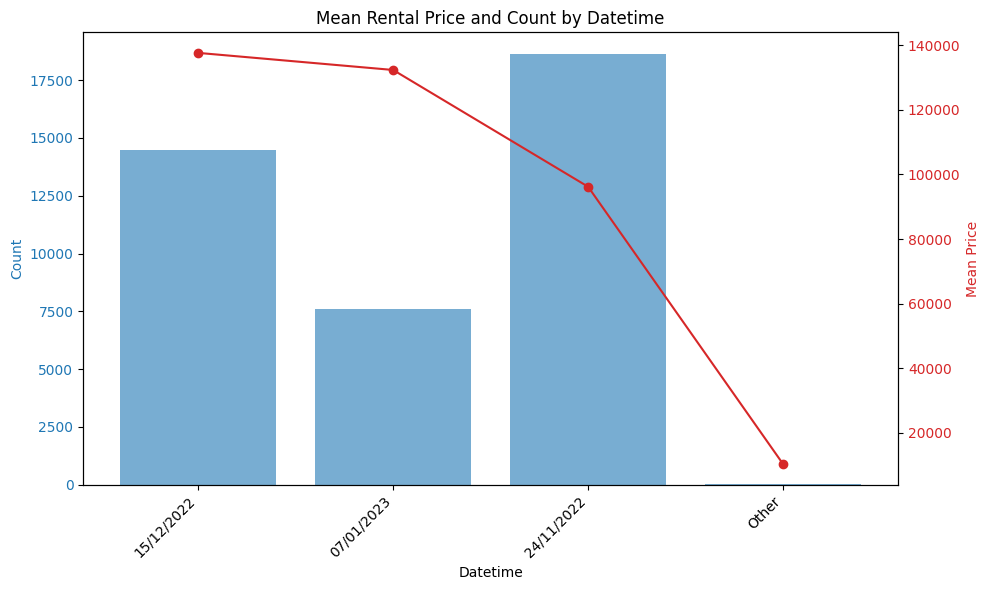

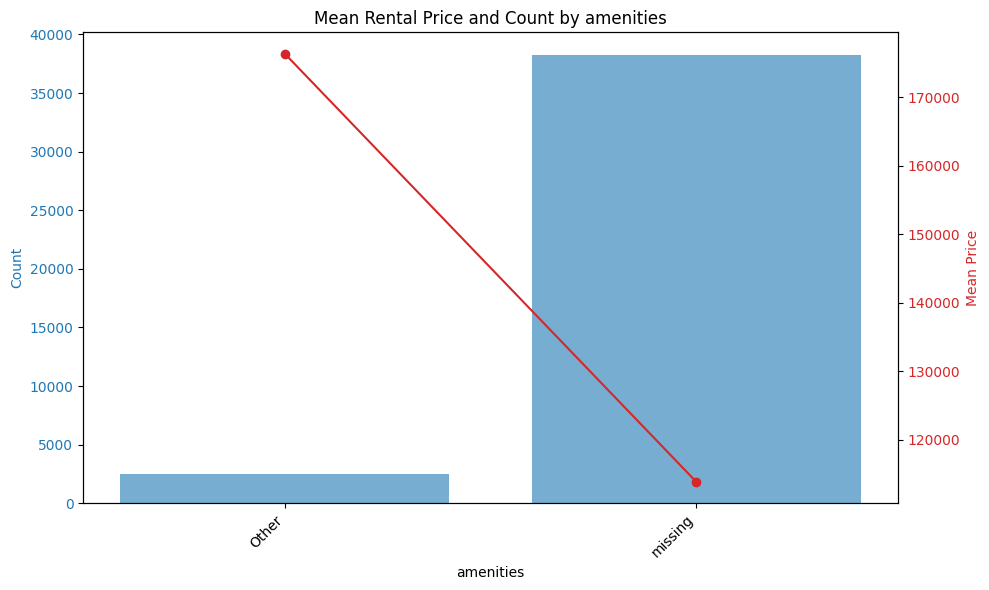

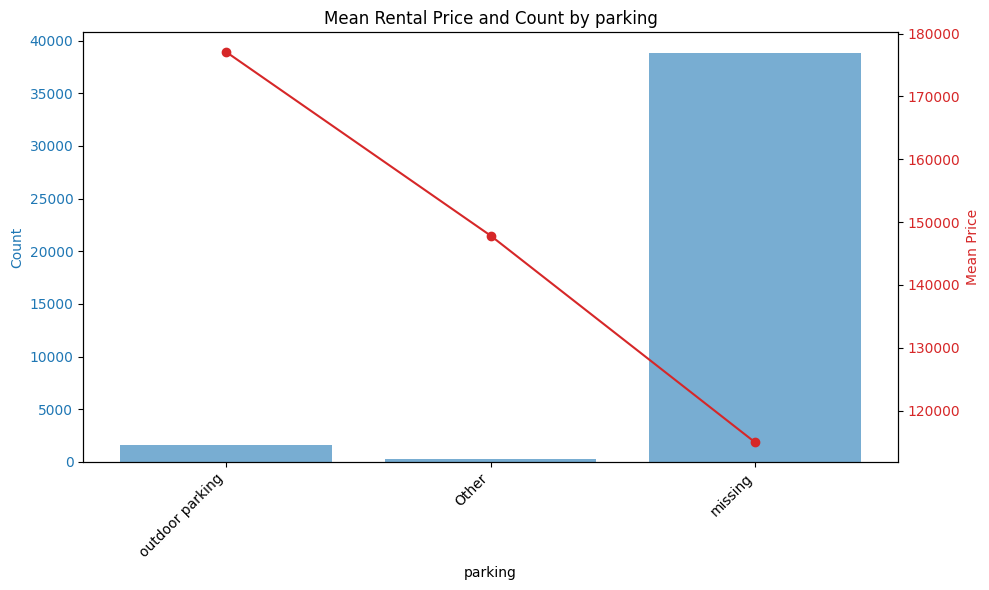

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Automatically detect categorical columns (dtype object or category)
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Output folder (adjust as needed)
output_folder = r"C:\Users\olivia\Downloads"

for col in categorical_columns:
    # Group by category: mean price and count
    grouped = data.groupby(col)['Price'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

    # Keep top 10 categories by mean price
    top_n = grouped.head(10)

    # Skip if fewer than 2 categories (not meaningful)
    if len(top_n) < 2:
        continue

    # Create figure with twin axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar plot: counts
    color = 'tab:blue'
    ax1.bar(top_n.index, top_n['count'], color=color, alpha=0.6)
    ax1.set_ylabel('Count', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlabel(col)
    ax1.set_xticks(range(len(top_n.index)))
    ax1.set_xticklabels(top_n.index, rotation=45, ha='right')

    # Line plot: mean price
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.plot(range(len(top_n.index)), top_n['mean'], color=color, marker='o')
    ax2.set_ylabel('Mean Price', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and layout
    plt.title(f'Mean Rental Price and Count by {col}')
    plt.tight_layout()

    # Save chart
    filename = f"{col}_combo_chart.png".replace(" ", "_").replace("/", "_")
    plt.savefig(os.path.join(output_folder, filename))

    # Show on screen (optional)
    plt.show()



In [171]:
# Identify categorical columns automatically
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Create a summary DataFrame
summary_stats = []

for col in categorical_columns:
    # Group by category and calculate mean and count
    group_stats = data.groupby(col)['Price'].agg(['mean', 'count'])
    
    # Filter low-support categories (optional, e.g. less than 10 listings)
    group_stats = group_stats[group_stats['count'] >= 10]

    if not group_stats.empty:
        mean_range = group_stats['mean'].max() - group_stats['mean'].min()
        mean_std = group_stats['mean'].std()
        summary_stats.append({
            'Attribute': col,
            'Mean Price Range': mean_range,
            'Std Dev of Means': mean_std,
            'Num Categories': group_stats.shape[0]
        })

# Convert to DataFrame
impact_summary = pd.DataFrame(summary_stats)

# Sort by Mean Price Range descending
impact_summary = impact_summary.sort_values(by='Mean Price Range', ascending=False)

impact_summary


Attribute  Mean Price Range  Std Dev of Means  Num Categories
5           Currency     230839.027563     124881.172305               3
2            Balcony     131581.606417      44074.142988               6
7           Datetime     127305.612908      58821.718162               4
4         Renovation     116251.416343      46675.150218               5
6           Duration     115600.032024      81741.566550               2
3          Furniture      90266.036656      37368.676959               4
1  Construction_type      84868.892469      36881.151550               4
8          amenities      62447.890275      44157.326684               2
9            parking      62160.416166      31098.198716               3
0             Gender       2878.125551       2035.142094               2

###### Grouped Summary


In [75]:
for col in categorical_columns:
    # Get top 10 categories by mean price
    top_10 = data.groupby(col)['Price'].mean().sort_values(ascending=False).head(10).index

    # Filter to those categories
    filtered = data[data[col].isin(top_10)]

    # Group and aggregate
    grouped_stats = (
        filtered.groupby(col)['Price']
        .agg(['mean', 'median', 'count'])
        .sort_values(by='mean', ascending=False)
    )

    # Display or export
    print(f"\nGrouped Summary Stats for {col} (Top 10 by Mean Price):\n")
    print(grouped_stats)
    # grouped_stats.to_csv(f"grouped_stats_top10_{col}.csv")  # Optional: save to file



Grouped Summary Stats for Gender (Top 10 by Mean Price):

                 mean  median  count
Gender                              
female  119084.082383  5500.0  20441
male    116205.956832  4500.0  20293

Grouped Summary Stats for Construction_type (Top 10 by Mean Price):

                            mean    median  count
Construction_type                                
cassette           231228.888889  230000.0     45
panels             161644.488291  120000.0   8839
stone              136930.462279   20000.0  15058
bricks             101710.126582   17000.0     79
missing             99357.142857   80000.0      7
monolith            76775.595821    1800.0  16703
wooden              57333.333333   18000.0      3

Grouped Summary Stats for Balcony (Top 10 by Mean Price):

                             mean    median  count
Balcony                                           
closed balcony      179681.606417  200000.0   6202
0                   135123.790946   20000.0   2717
not avail

### --- EDA COMPLETED --- ###

### Feature creation and transformation


#### Drop columns high cardinality

In [79]:
## Drop unneeded columns
data_copy = data
columns_to_drop = ['Reg_id', 'Address','appliances']
data = data.drop(columns=columns_to_drop)

# Reg ID - acts as a unique identier, address amenties and appliances high cardinality, datetime unstructure string, parking hard to model directly

#### Drop or recategorise under-represented values

Witten et al. (Ch. 8.1) implies this during discussions of feature relevance and filtering. Low-frequency values are often not statistically significant or informative, which aligns with the “irrelevant features” they recommend removing.



In [81]:
data.dtypes

Gender                     object
Age                         int64
Construction_type          object
New_construction          float64
Elevator                  float64
Floors_in_the_building    float64
Floor_area                float64
Number_of_rooms           float64
Number_of_bathrooms       float64
Ceiling_height            float64
Floor                     float64
Balcony                    object
Furniture                  object
Renovation                 object
Children_are_welcome      float64
Pets_allowed              float64
Utility_payments          float64
Price                     float64
Currency                   object
Duration                   object
Datetime                   object
amenities                  object
parking                    object
is_train                     bool
dtype: object

In [83]:
# Set percentage threshold
percent_threshold = 0.02  # 2%
min_count = data.shape[0] * percent_threshold

# Replace infrequent categories with 'Other'
for col in data.select_dtypes(include='object').columns:
    if col == "Address":
        continue
    value_counts = data[col].value_counts()
    to_replace = value_counts[(value_counts < min_count) &(value_counts != 'missing')].index
    data[col] = data[col].replace(to_replace, 'Other')




#### Feature Creation


In [85]:

# Create new features
data['Price_per_sqm'] = data['Price'] / data['Floor_area']
data['Rooms_per_floor'] = data['Number_of_rooms'] / data['Floors_in_the_building']
data['Bathrooms_per_room'] = data['Number_of_bathrooms'] / data['Number_of_rooms']
data['Ceiling_volume'] = data['Ceiling_height'] * data['Floor_area']
data['Floor_squared'] = data['Floor'] ** 2

# Optional binary indicators based on presence
data['Has_balcony'] = data['Balcony'].apply(lambda x: 0 if x == 'missing' else 1)
data['Is_furnished'] = data['Furniture'].apply(lambda x: 0 if x == 'missing' else 1)

# Check the newly created features
new_features = ['Price_per_sqm', 'Rooms_per_floor', 'Bathrooms_per_room',
                'Ceiling_volume', 'Floor_squared', 'Has_balcony', 'Is_furnished']



In [87]:
# Only include categorical (object or category) columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# Get the number of unique values in each categorical column
data[categorical_cols].nunique()

data_before_encoding

Gender               2
Construction_type    4
Balcony              6
Furniture            4
Renovation           5
Currency             3
Duration             3
Datetime             4
amenities            2
parking              3
dtype: int64

##### One Hot encoding

In [89]:
# Preparing date for the model by one hot encoding
# Step 1: Identify categorical columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Step 1: Identify original numeric columns
numeric_columns = data.select_dtypes(include=['number']).columns.tolist()

#Boolean colums
bools_cols = data.select_dtypes(include=['bool']).columns.tolist()
data_bools = data[bools_cols]

# Step 2: Extract only numeric data
data_numeric = data[numeric_columns]

# Step 3: Extract only encoded (new dummy) columns
encoded_dummies = pd.get_dummies(data[categorical_columns])

# Step 4: Combine numeric and encoded columns
final_data = pd.concat([data_numeric, encoded_dummies, data_bools], axis=1)

# Optional: Check result
print(f"Final dataset shape: {final_data.shape}")


Final dataset shape: (40734, 57)


#### Observing Correlation

##### High correlation pairs

In [145]:

# Step 1: Compute correlation matrix for numeric columns
corr_matrix = final_data.corr()

# Step 2: Mask the upper triangle to avoid duplicates and self-correlation (e.g. price vs price = 1)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
filtered_corr = corr_matrix.where(mask)

# Step 3: Stack the matrix into a long-form DataFrame and filter by threshold
threshold = 0.3
high_corr_df = (
    filtered_corr.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)

# Step 4: Keep only correlations above threshold (positive or negative)
high_corr_df = high_corr_df[high_corr_df['Correlation'].abs() > threshold]

# Step 5: Sort by absolute correlation
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)



##### Correlation Matrices

###### Correlation matrix for Rooms, price and duration

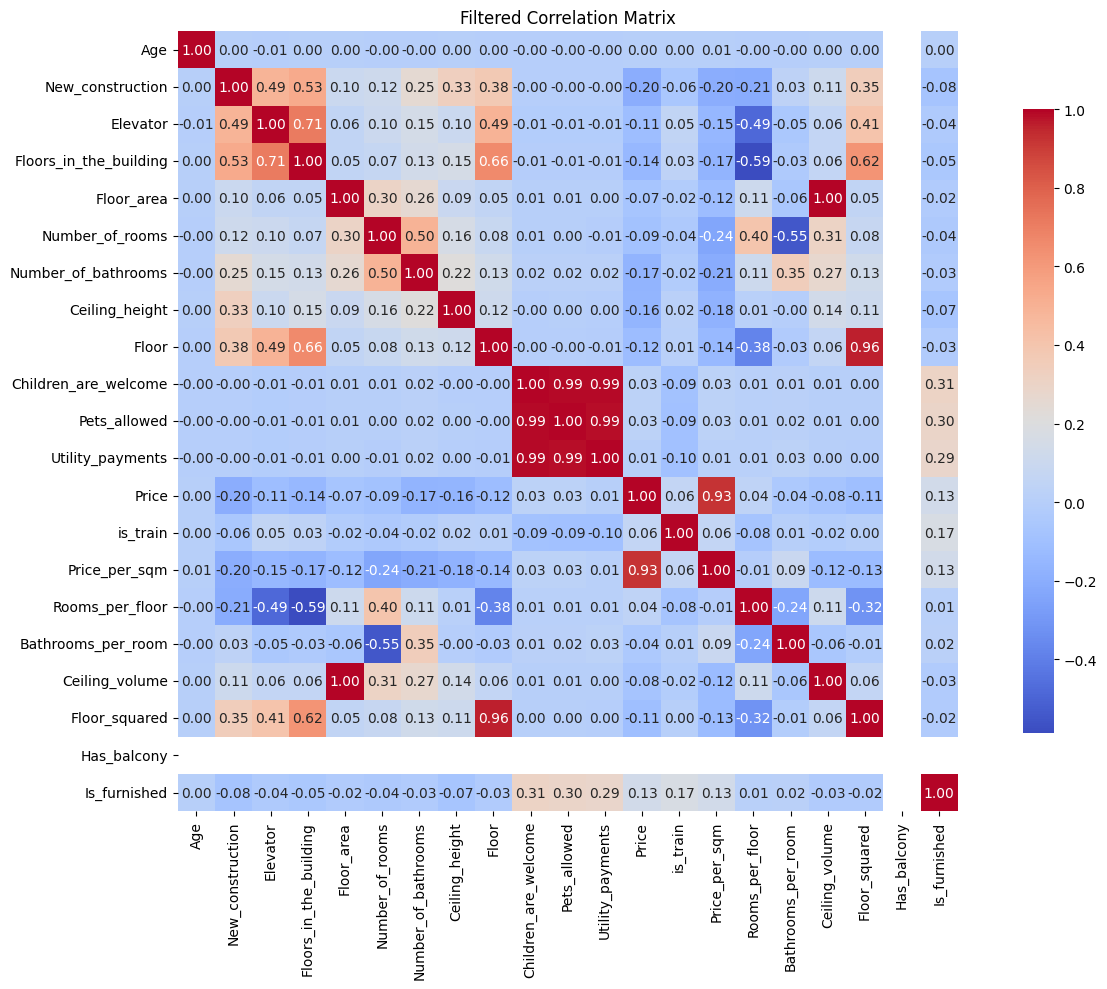

In [157]:
df_selected = data

# Use final_data as the actual dataset
corr_matrix = df_selected.corr(numeric_only=True)

# Plot the filtered correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Filtered Correlation Matrix")
plt.tight_layout()
plt.show()


<Axes: xlabel='Duration', ylabel='Price'>

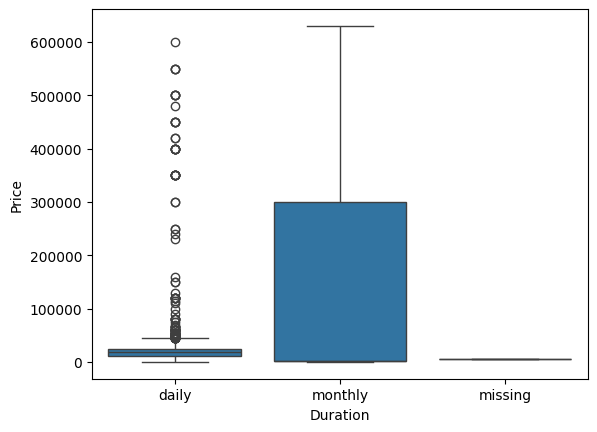

In [324]:
sns.boxplot(x='Duration', y='Price', data=data)

<Axes: xlabel='Duration', ylabel='Number_of_rooms'>

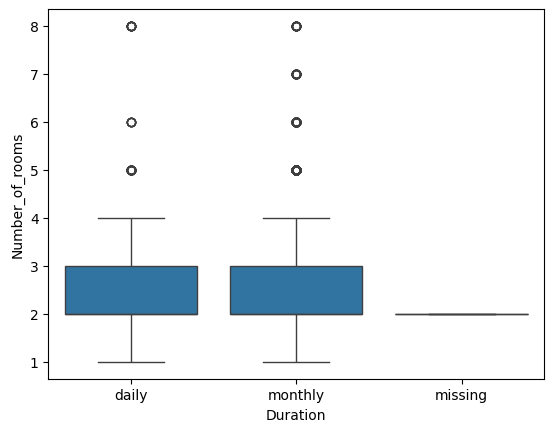

In [807]:
sns.boxplot(x='Duration', y='Number_of_rooms', data=data) 

###### ANOVA to see relationships of duration columns

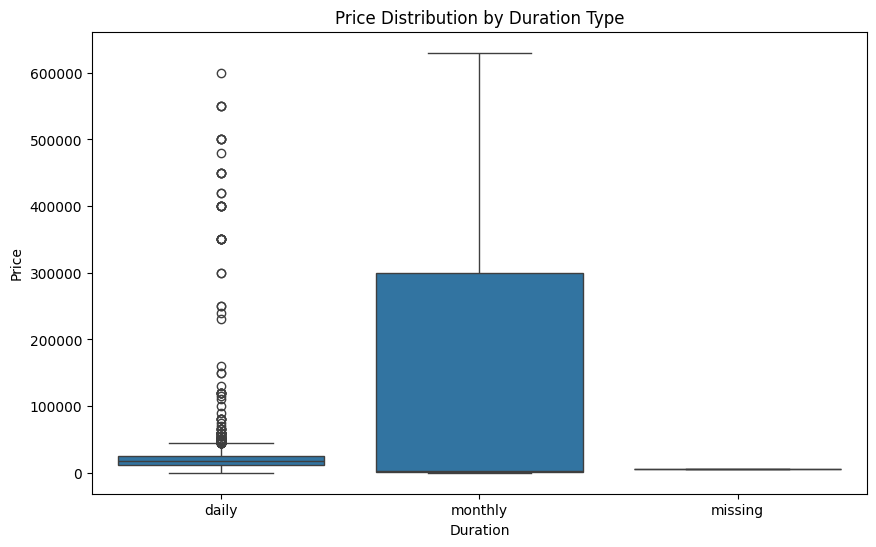

ANOVA result: F_onewayResult(statistic=np.float64(1330.2894256320833), pvalue=np.float64(0.0))
Statistically significant difference in Price between durations (p < 0.05)


In [813]:
data_anova = final_data

# Reconstruct a single Duration column from dummy vars
def get_duration(row):
    if row['Duration_monthly'] == 1:
        return 'monthly'
    elif row['Duration_daily'] == 1:
        return 'daily'
    elif row['Duration_missing'] == 1:
        return 'missing'
    else:
        return 'unknown'

# Apply to your data
data_anova['Duration'] = data_anova.apply(get_duration, axis=1)

# Drop unknown if needed
data_anova = data_anova[data_anova['Duration'] != 'unknown']

# Boxplot to show price distribution by duration
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_anova, x='Duration', y='Price')
plt.title('Price Distribution by Duration Type')
plt.show()

# Run one-way ANOVA
daily_prices = data_anova[data_anova['Duration'] == 'daily']['Price']
monthly_prices = data_anova[data_anova['Duration'] == 'monthly']['Price']
missing_prices = data_anova[data_anova['Duration'] == 'missing']['Price']

anova_result = f_oneway(daily_prices, monthly_prices, missing_prices)

# Print result
print("ANOVA result:", anova_result)
if anova_result.pvalue < 0.05:
    print("Statistically significant difference in Price between durations (p < 0.05)")
else:
    print("❌ No significant difference in Price between durations (p ≥ 0.05)")


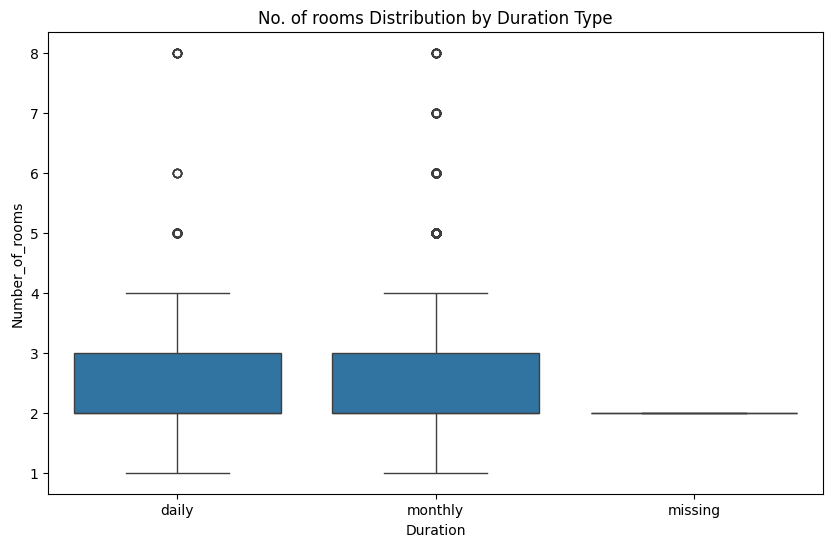

ANOVA result: F_onewayResult(statistic=np.float64(1330.2894256320833), pvalue=np.float64(0.0))
✅ Statistically significant difference (p < 0.05)


In [815]:
data_anova = final_data

# Reconstruct a single Duration column from dummy vars
def get_duration(row):
    if row['Duration_monthly'] == 1:
        return 'monthly'
    elif row['Duration_daily'] == 1:
        return 'daily'
    elif row['Duration_missing'] == 1:
        return 'missing'
    else:
        return 'unknown'

# Apply to your data
data_anova['Duration'] = data_anova.apply(get_duration, axis=1)

# Drop unknown if needed
data_anova = data_anova[data_anova['Duration'] != 'unknown']

# Boxplot to show price distribution by duration
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_anova, x='Duration', y='Number_of_rooms')
plt.title('No. of rooms Distribution by Duration Type')
plt.show()

# Run one-way ANOVA
daily_prices = data_anova[data_anova['Duration'] == 'daily']['Price']
monthly_prices = data_anova[data_anova['Duration'] == 'monthly']['Price']
missing_prices = data_anova[data_anova['Duration'] == 'missing']['Price']

anova_result = f_oneway(daily_prices, monthly_prices, missing_prices)

# Print result
print("ANOVA result:", anova_result)
if anova_result.pvalue < 0.05:
    print("✅ Statistically significant difference (p < 0.05)")
else:
    print("❌ No significant difference (p ≥ 0.05)")

In [640]:
final_cat_remove = final_data.select_dtypes(include=['object', 'category']).columns.tolist()
final_data = final_data.drop(columns=final_cat_remove)
print(final_data.dtypes)

Age                                                   int64
New_construction                                    float64
Elevator                                            float64
Floors_in_the_building                              float64
Floor_area                                          float64
                                                     ...   
parking_outdoor parking                                bool
parking_outdoor parking, covered parking               bool
parking_outdoor parking, covered parking, garage       bool
parking_outdoor parking, garage                        bool
is_train                                               bool
Length: 89, dtype: object


# Prepping & Building models

#### Reducing Multicollinearity


In [91]:
# List of features to drop based on correlation and redundancy
features_to_drop = [
    'Children_are_welcome',  # strongly correlated with Utility_payments
    'Pets_allowed',          # same reason
    'Price_per_sqm',                 # redundant with Price
    'Floor_squared',         # redundant with Floor
    'Ceiling_volume'         # derived from Ceiling_height and Floor_area
]

# Drop these features from the dataset
data_reduced = final_data.drop(columns=features_to_drop)

print("Dropped features:", features_to_drop)
print("Remaining shape:", data_reduced.shape)


Dropped features: ['Children_are_welcome', 'Pets_allowed', 'Price_per_sqm', 'Floor_squared', 'Ceiling_volume']
Remaining shape: (40734, 52)


#### Feature Scaling & X / Y TRAIN TEST SPLIT

In [93]:

# Step 1: Prepare data
# Separate features and target
X = data_reduced.drop(['Price'], axis=1)
y = data_reduced['Price']

# Use the is_train flag to split
X_train = X[data_reduced['is_train'] == 1]
X_test = X[data_reduced['is_train'] == 0]
y_train = y[data_reduced['is_train'] == 1]
y_test = y[data_reduced['is_train'] == 0]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#### Feature Selection




In [648]:
## MI Scores
mi_scores = mutual_info_regression(X_scaled, y)  # X_scaled is your one-hot encoded, scaled data
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Select top 20 features
top_features_mi = mi_series.head(20).index.tolist()

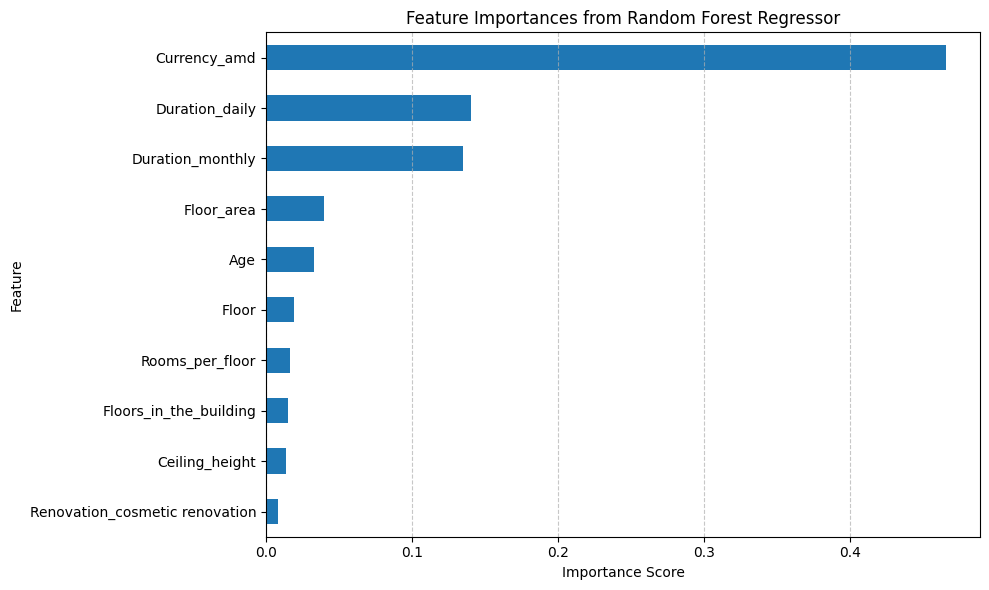

In [789]:
## Random forest regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_scaled, y)

rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
rf_importances_sorted = rf_importances.sort_values(ascending=True).tail(10)



# Plot

plt.figure(figsize=(10, 6))

rf_importances_sorted.plot(kind='barh')

plt.title('Feature Importances from Random Forest Regressor')

plt.xlabel('Importance Score')

plt.ylabel('Feature')

plt.tight_layout()

plt.grid(axis='x', linestyle='--', alpha=0.7)



In [652]:
## Correlation
correlations = pd.DataFrame(X_scaled, columns=X.columns).corrwith(y).abs().sort_values(ascending=False)
top_features_corr = correlations.head(20).index.tolist()


#### Model Building - singular - random forest

RMSE: 7867312886.54
MAE: 43809.97
R²: 0.67
MSE: 7867312886.54


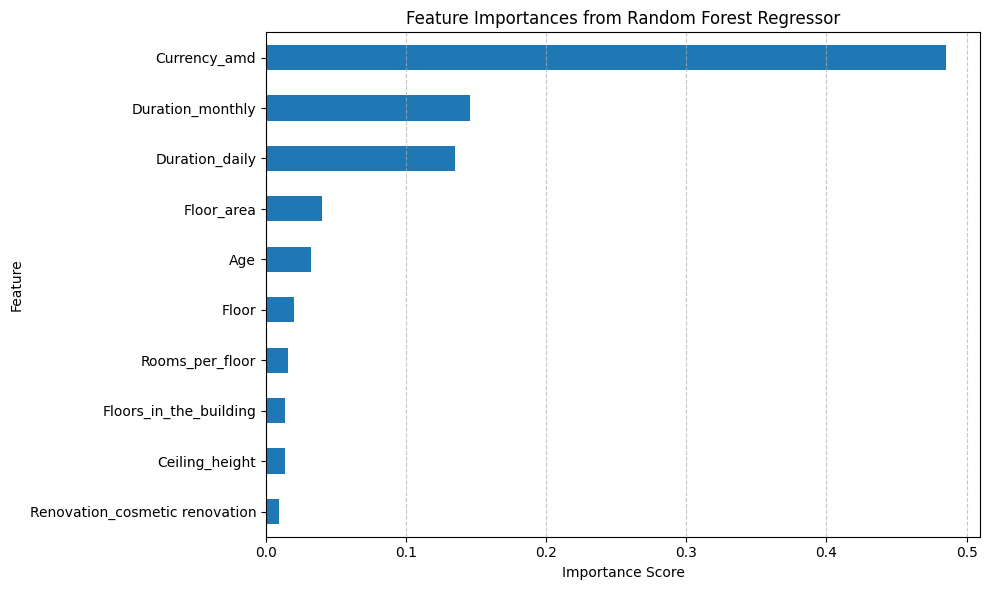

In [135]:
## Random forest regressor
from sklearn.ensemble import RandomForestRegressor

X_train = X[data_reduced['is_train'] == 1]
X_test = X[data_reduced['is_train'] == 0]
y_train = y[data_reduced['is_train'] == 1]
y_test = y[data_reduced['is_train'] == 0]

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train,y_train)

rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
rf_importances_sorted = rf_importances.sort_values(ascending=True).tail(10)

# Plot
plt.figure(figsize=(10, 6))
rf_importances_sorted.plot(kind='barh')
plt.title('Feature Importances from Random Forest Regressor')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"MSE: {mse:.2f}")

#### Model building and evaluation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline

# Use the is_train flag to split
X_train = X[data_reduced['is_train'] == 1]
X_test = X[data_reduced['is_train'] == 0]
y_train = y[data_reduced['is_train'] == 1]
y_test = y[data_reduced['is_train'] == 0]


# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Store results
results = []

# Evaluate each model
for name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    rmse = -cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error', cv=cv).mean()
    r2 = cross_val_score(pipeline, X, y, scoring='r2', cv=cv).mean()
    mae = -cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv).mean()
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print(results_df)


#### Checking whether the data matches with linear regression assumption


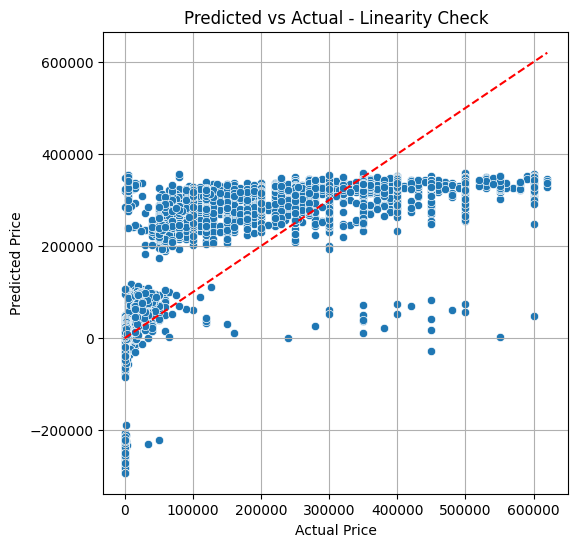

R² Score: 0.5835
MSE: 9976459810.24


Feature   Coefficient
36                    Currency_amd  7.842632e+04
37                    Currency_usd -7.831474e+04
39                  Duration_daily -4.452633e+04
40                Duration_monthly  4.451178e+04
11              Bathrooms_per_room -1.370068e+04
30                Renovation_Other -1.101295e+04
31  Renovation_cosmetic renovation -9.483834e+03
6              Number_of_bathrooms  6.926309e+03
7                   Ceiling_height  4.653224e+03
10                 Rooms_per_floor -4.516446e+03
1                 New_construction -4.432712e+03
34     Renovation_major renovation  3.899285e+03
9                 Utility_payments  3.778688e+03
18        Construction_type_panels -3.597441e+03
17      Construction_type_monolith  3.554863e+03
26                     Furniture_1  3.514133e+03
43             Datetime_24/11/2022  3.216574e+03
33      Renovation_euro renovation  3.089359e+03
27                 Furniture_Other -3.022442e+03
41             Datetime_07/01/2023 -2.992312e+03
32  Renovation_designer renovation  2.473266e+03
2                         Elevator  2.424477e+03
25            Balcony_open balcony  2.122995e+03
35                  Currency_Other -2.058924e+03
5                  Number_of_rooms -1.989066e+03
49         parking_outdoor parking -1.759727e+03
22          Balcony_closed balcony -1.649536e+03
48                 parking_missing  1.635290e+03
29               Furniture_missing -1.373270e+03
13                    Is_furnished  1.373270e+03
16         Construction_type_Other -1.304943e+03
23      Balcony_multiple balconies -1.022584e+03
4                       Floor_area -9.115685e+02
28             Furniture_available -5.924915e+02
21                   Balcony_Other  5.752062e+02
42             Datetime_15/12/2022 -5.610213e+02
45                 amenities_Other -5.085895e+02
46               amenities_missing  5.085895e+02
24           Balcony_not available -4.668584e+02
3           Floors_in_the_building -4.630651e+02
15                     Gender_male -4.386899e+02
14                   Gender_female  4.386899e+02
19         Construction_type_stone -3.424332e+02
44                  Datetime_Other  3.207238e+02
38                  Duration_Other  3.207238e+02
8                            Floor -2.683842e+02
0                              Age  2.585944e+02
20                       Balcony_0 -7.603242e+01
47                   parking_Other  3.251155e+01
12                     Has_balcony -7.275958e-12
50                        is_train  0.000000e+00

In [133]:
### Linearity assumption

import matplotlib.pyplot as plt
import seaborn as sns

# Fit model on full training data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Plot predicted vs actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual - Linearity Check")
plt.grid(True)
plt.show()


r2 = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")

print(f"MSE: {mse:.2f}")



# === 3. Feature importance (coefficients) ===

# Extract feature names (if using pipeline)

if hasattr(pipeline.named_steps['linearregression'], 'coef_'):

    coefs = pipeline.named_steps['linearregression'].coef_

    feature_names = X.columns  # assuming X is a DataFrame

    coef_df = pd.DataFrame({

        'Feature': feature_names,

        'Coefficient': coefs

    }).sort_values(by='Coefficient', key=abs, ascending=False)

    display(coef_df)

else:

    print("Coefficients not available.")


In [161]:
# List to hold individual R² scores
r2_scores = []

# Loop through each feature to calculate R² when used alone
for col in X.columns:
    x_col = X[[col]]
    model = LinearRegression()
    model.fit(x_col, y)
    y_pred_col = model.predict(x_col)
    score = r2_score(y, y_pred_col)
    r2_scores.append(score)

# Add R² to coef_df
coef_df['R2 Score (Single Feature)'] = r2_scores

# Sort and display
coef_df = coef_df.sort_values(by='R2 Score (Single Feature)', ascending=False)
display(coef_df)

Feature   Coefficient  R2 Score (Single Feature)
45                 amenities_Other -5.085895e+02                   0.465859
46               amenities_missing  5.085895e+02                   0.464714
15                     Gender_male -4.386899e+02                   0.061315
3           Floors_in_the_building -4.630651e+02                   0.061286
33      Renovation_euro renovation  3.089359e+03                   0.040630
37                    Currency_usd -7.831474e+04                   0.040020
4                       Floor_area -9.115685e+02                   0.030598
31  Renovation_cosmetic renovation -9.483834e+03                   0.028937
6              Number_of_bathrooms  6.926309e+03                   0.025924
25            Balcony_open balcony  2.122995e+03                   0.024179
40                Duration_monthly  4.451178e+04                   0.020182
27                 Furniture_Other -3.022442e+03                   0.018767
13                    Is_furnished  1.373270e+03                   0.017286
18        Construction_type_panels -3.597441e+03                   0.017286
49         parking_outdoor parking -1.759727e+03                   0.016962
7                   Ceiling_height  4.653224e+03                   0.013861
44                  Datetime_Other  3.207238e+02                   0.013584
39                  Duration_daily -4.452633e+04                   0.012390
23      Balcony_multiple balconies -1.022584e+03                   0.012350
30                Renovation_Other -1.101295e+04                   0.008170
8                            Floor -2.683842e+02                   0.007751
0                              Age  2.585944e+02                   0.007751
19         Construction_type_stone -3.424332e+02                   0.007703
41             Datetime_07/01/2023 -2.992312e+03                   0.007627
47                   parking_Other  3.251155e+01                   0.005290
12                     Has_balcony -7.275958e-12                   0.005219
11              Bathrooms_per_room -1.370068e+04                   0.004661
16         Construction_type_Other -1.304943e+03                   0.004204
29               Furniture_missing -1.373270e+03                   0.003775
50                        is_train  0.000000e+00                   0.003543
22          Balcony_closed balcony -1.649536e+03                   0.003502
48                 parking_missing  1.635290e+03                   0.002917
21                   Balcony_Other  5.752062e+02                   0.001896
34     Renovation_major renovation  3.899285e+03                   0.001823
14                   Gender_female  4.386899e+02                   0.001737
1                 New_construction -4.432712e+03                   0.001696
28             Furniture_available -5.924915e+02                   0.001538
32  Renovation_designer renovation  2.473266e+03                   0.000763
35                  Currency_Other -2.058924e+03                   0.000576
5                  Number_of_rooms -1.989066e+03                   0.000382
42             Datetime_15/12/2022 -5.610213e+02                   0.000204
20                       Balcony_0 -7.603242e+01                   0.000195
38                  Duration_Other  3.207238e+02                   0.000119
43             Datetime_24/11/2022  3.216574e+03                   0.000081
26                     Furniture_1  3.514133e+03                   0.000072
17      Construction_type_monolith  3.554863e+03                   0.000072
10                 Rooms_per_floor -4.516446e+03                   0.000050
2                         Elevator  2.424477e+03                   0.000046
24           Balcony_not available -4.668584e+02                   0.000022
36                    Currency_amd  7.842632e+04                   0.000020
9                 Utility_payments  3.778688e+03                   0.000000

In [222]:
### Multicollinearity assumption

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add intercept and scale features
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X_scaled = add_constant(X_scaled)

# Calculate VIFs
vif = pd.DataFrame()
vif["feature"] = X_scaled.columns
vif["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
print(vif.sort_values(by="VIF", ascending=False))

C:\Users\olivia\anaconda3\envs\ortools_env\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                           feature           VIF
48                   parking_Other  5.892115e+09
17         Construction_type_Other  3.442807e+09
36                  Currency_Other  7.230156e+08
47               amenities_missing  3.652052e+08
50         parking_outdoor parking  1.683083e+08
46                 amenities_Other  1.434371e+08
45                  Datetime_Other  1.417971e+08
49                 parking_missing  1.291757e+08
39                  Duration_Other  9.500288e+07
32  Renovation_cosmetic renovation  9.008669e+07
31                Renovation_Other  8.139385e+07
22                   Balcony_Other  7.326279e+07
28                 Furniture_Other  6.077683e+07
23          Balcony_closed balcony  3.087039e+07
26            Balcony_open balcony  2.385547e+07
25           Balcony_not available  1.676271e+07
21                       Balcony_0  1.541562e+07
24      Balcony_multiple balconies  1.510862e+07
37                    Currency_amd  1.506337e+07
34      Renovation_e